## <center>Курсовой проект<a class="anchor" id="course_project"></a><center>

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from scipy.spatial.distance import cdist
from scipy.stats import shapiro
from scipy.stats import ttest_ind
from scipy.stats import probplot
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, PolynomialFeatures
from sklearn.model_selection import StratifiedKFold
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = "png"
np.random.seed(42)

In [2]:
train_df = pd.read_csv("course_project_train.csv")

In [3]:
train_df.head()

Home Ownership  Annual Income Years in current job  Tax Liens  \
0       Own Home       482087.0                  NaN        0.0   
1       Own Home      1025487.0            10+ years        0.0   
2  Home Mortgage       751412.0              8 years        0.0   
3       Own Home       805068.0              6 years        0.0   
4           Rent       776264.0              8 years        0.0   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                     11.0                     26.3             685960.0   
1                     15.0                     15.3            1181730.0   
2                     11.0                     35.0            1182434.0   
3                      8.0                     22.5             147400.0   
4                     13.0                     13.6             385836.0   

   Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                        1.0                           NaN           1.0   
1                        0.0                           NaN           0.0   
2                        0.0                           NaN           0.0   
3                        1.0                           NaN           1.0   
4                        1.0                           NaN           0.0   

              Purpose        Term  Current Loan Amount  \
0  debt consolidation  Short Term           99999999.0   
1  debt consolidation   Long Term             264968.0   
2  debt consolidation  Short Term           99999999.0   
3  debt consolidation  Short Term             121396.0   
4  debt consolidation  Short Term             125840.0   

   Current Credit Balance  Monthly Debt  Credit Score  Credit Default  
0                 47386.0        7914.0         749.0               0  
1                394972.0       18373.0         737.0               1  
2                308389.0       13651.0         742.0               0  
3                 95855.0       11338.0         694.0               0  
4                 93309.0        7180.0         719.0               0

In [4]:
train_df.shape

(7500, 17)

In [5]:
test_df = pd.read_csv("course_project_test.csv")

In [6]:
test_df.head()

Home Ownership  Annual Income Years in current job  Tax Liens  \
0           Rent            NaN              4 years        0.0   
1           Rent       231838.0               1 year        0.0   
2  Home Mortgage      1152540.0              3 years        0.0   
3  Home Mortgage      1220313.0            10+ years        0.0   
4  Home Mortgage      2340952.0              6 years        0.0   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                      9.0                     12.5             220968.0   
1                      6.0                     32.7              55946.0   
2                     10.0                     13.7             204600.0   
3                     16.0                     17.0             456302.0   
4                     11.0                     23.6            1207272.0   

   Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                        0.0                          70.0           0.0   
1                        0.0                           8.0           0.0   
2                        0.0                           NaN           0.0   
3                        0.0                          70.0           0.0   
4                        0.0                           NaN           0.0   

                Purpose        Term  Current Loan Amount  \
0    debt consolidation  Short Term             162470.0   
1  educational expenses  Short Term              78298.0   
2    debt consolidation  Short Term             200178.0   
3    debt consolidation  Short Term             217382.0   
4    debt consolidation   Long Term             777634.0   

   Current Credit Balance  Monthly Debt  Credit Score  
0                105906.0        6813.0           NaN  
1                 46037.0        2318.0         699.0  
2                146490.0       18729.0        7260.0  
3                213199.0       27559.0         739.0  
4                425391.0       42605.0         706.0

In [7]:
test_df.shape

(2500, 16)

In [8]:
train_df.shape[1]-1 == test_df.shape[1]

True

### Уменьшим размер данных в памяти и приведём их к единому типу

In [9]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [10]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.38 MB
Decreased by 60.9%
Memory usage of dataframe is 0.31 MB
Memory usage after optimization is: 0.13 MB
Decreased by 58.9%


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                7500 non-null   category
 1   Annual Income                 5943 non-null   float32 
 2   Years in current job          7129 non-null   category
 3   Tax Liens                     7500 non-null   float32 
 4   Number of Open Accounts       7500 non-null   float32 
 5   Years of Credit History       7500 non-null   float32 
 6   Maximum Open Credit           7500 non-null   float32 
 7   Number of Credit Problems     7500 non-null   float32 
 8   Months since last delinquent  3419 non-null   float32 
 9   Bankruptcies                  7486 non-null   float32 
 10  Purpose                       7500 non-null   category
 11  Term                          7500 non-null   category
 12  Current Loan Amount           7500 non-null   fl

# EDA

* поиск и исправление выбросов
* поиск и заполнение пропусков
* идеи для генерации новых признаков

### Целевая переменная

In [12]:
y = train_df['Credit Default']
y.value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [13]:
def display_clusters_distribution(df):
    unique = df.value_counts().index.tolist()
    counts = df.value_counts().values.tolist()
        
    """Визуализация распределения классов по кластерам"""
    #plt.figure(figsize=(8,5))

    plt.bar(unique, counts)

    plt.xlabel('Clusters')
    plt.xticks(unique)
    plt.ylabel('Count')
    plt.title('Clusters distribution')
    plt.xticks(rotation=45)
    plt.show()

In [14]:
def boxplot(df, y, feature):
    sns.set(rc={'figure.figsize':(20,10)})
    plt.xticks(rotation=45)
    sns.boxplot(df[feature], y)
    plt.show()
    plt.close()

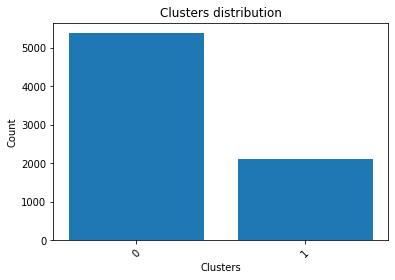

In [15]:
display_clusters_distribution(y)

### Целевая переменная несбалансирована, нужно будет попробовать расширить набор данных, например оверсемплингом

## Посмотрим категориальные данные

Признак: Home Ownership


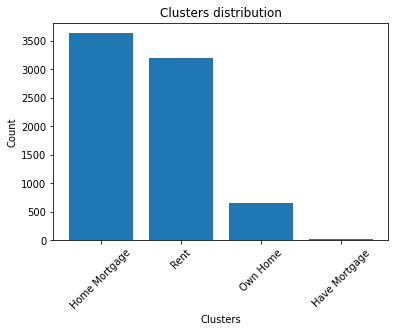

Признак: Years in current job


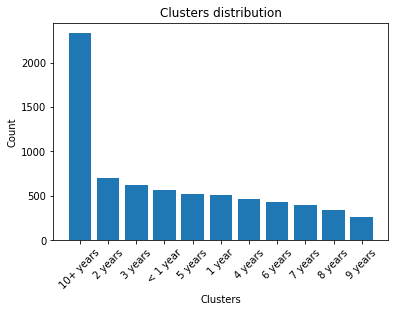

Признак: Purpose


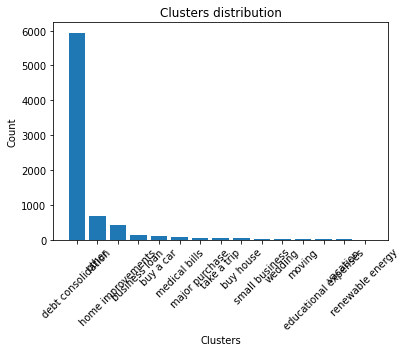

Признак: Term


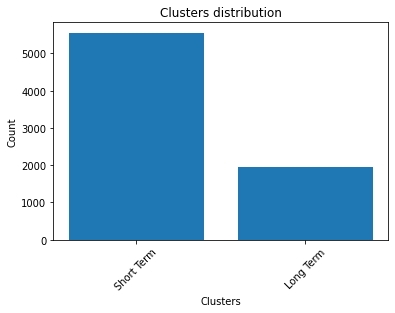

In [16]:
categories = train_df.select_dtypes(include="category").columns.tolist()
numerical = train_df.select_dtypes(exclude="category").columns.tolist()

for feature in categories:
    print(f"Признак: {feature}")
    display_clusters_distribution(train_df[feature])
    

### С признаками всё в порядке, один Purpose излишне несбалансирован, возможно стоит выразить его через свою численность

## Посмотрим числовые данные

In [17]:
def deviations(series):
  median = series.quantile(q=0.5)
  avg = series.mean()
  std = series.std()
  mode = series.mode()[0]
  print(f"Медиана со средним значением отличаются на {round(abs(median-avg)/std, 2):.02f} стандартных отклонения")
  if series.min() < median-std*3:
    print(f"Минимальное значение меньше, чем медиана - 3 стандартных отклонения (выходит из 99,7% диапазона данных)")
  if series.max() > median+std*3:
    print(f"Максимальное значение больше, чем медиана + 3 стандартных отклонения (выходит из 99,7% диапазона данных)")
  return median, avg, mode

In [18]:
def hist_plot(df, feature, median, avg, mode):
    #sns.set(rc={'figure.figsize':(20,10)})
    sns.distplot(df[feature])
    plt.axvline(median, c="red", label="median")
    plt.axvline(avg, c="green", label="average")
    plt.axvline(mode, c="orange", label="mode")
    plt.legend(loc="best", frameon=False)
    plt.title(feature)
    fig = plt.figure()
    #res = stats.probplot(df[feature], plot=plt)
    plt.show()
    plt.close()

Признак: Annual Income
count    5.943000e+03
mean     1.366392e+06
std      8.453392e+05
min      1.645970e+05
25%      8.443410e+05
50%      1.168386e+06
75%      1.640137e+06
max      1.014934e+07
Name: Annual Income, dtype: float64
1043651.0    4
1161660.0    4
1338113.0    4
969475.0     4
1058376.0    4
            ..
2185646.0    1
2326075.0    1
330429.0     1
1704965.0    1
648166.0     1
Name: Annual Income, Length: 5478, dtype: int64
Медиана со средним значением отличаются на 0.23 стандартных отклонения
Максимальное значение больше, чем медиана + 3 стандартных отклонения (выходит из 99,7% диапазона данных)


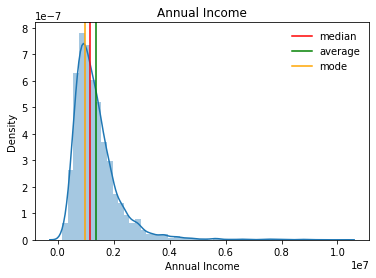

<Figure size 432x288 with 0 Axes>

Признак: Tax Liens
count    7500.000000
mean        0.030133
std         0.271604
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         7.000000
Name: Tax Liens, dtype: float64
0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64
Медиана со средним значением отличаются на 0.11 стандартных отклонения
Максимальное значение больше, чем медиана + 3 стандартных отклонения (выходит из 99,7% диапазона данных)


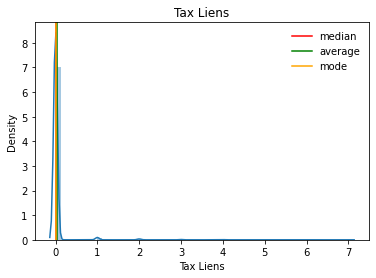

<Figure size 432x288 with 0 Axes>

Признак: Number of Open Accounts
count    7500.000000
mean       11.130934
std         4.908924
min         2.000000
25%         8.000000
50%        10.000000
75%        14.000000
max        43.000000
Name: Number of Open Accounts, dtype: float64
9.0     728
11.0    692
10.0    677
8.0     638
7.0     613
12.0    562
6.0     504
13.0    465
14.0    420
5.0     325
15.0    313
16.0    265
17.0    232
4.0     212
18.0    143
19.0    139
3.0      95
20.0     93
21.0     78
23.0     59
24.0     50
22.0     49
25.0     32
2.0      28
28.0     14
27.0     14
26.0     12
30.0     11
29.0     10
33.0      6
31.0      6
32.0      6
34.0      2
37.0      2
42.0      1
43.0      1
35.0      1
38.0      1
41.0      1
Name: Number of Open Accounts, dtype: int64
Медиана со средним значением отличаются на 0.23 стандартных отклонения
Максимальное значение больше, чем медиана + 3 стандартных отклонения (выходит из 99,7% диапазона данных)


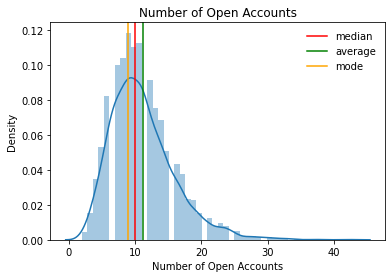

<Figure size 432x288 with 0 Axes>

Признак: Years of Credit History
count    7500.000000
mean       18.317467
std         7.041946
min         4.000000
25%        13.500000
50%        17.000000
75%        21.799999
max        57.700001
Name: Years of Credit History, dtype: float64
15.000000    104
16.000000     99
16.500000     91
17.000000     86
17.500000     83
            ... 
44.000000      1
42.299999      1
36.700001      1
49.099998      1
44.799999      1
Name: Years of Credit History, Length: 408, dtype: int64
Медиана со средним значением отличаются на 0.19 стандартных отклонения
Максимальное значение больше, чем медиана + 3 стандартных отклонения (выходит из 99,7% диапазона данных)


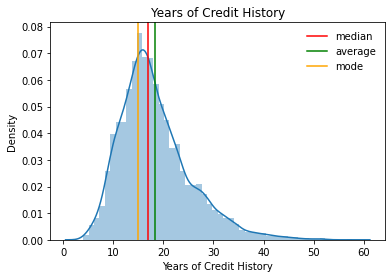

<Figure size 432x288 with 0 Axes>

Признак: Maximum Open Credit
count    7.500000e+03
mean     9.451538e+05
std      1.602622e+07
min      0.000000e+00
25%      2.792295e+05
50%      4.781590e+05
75%      7.935015e+05
max      1.304726e+09
Name: Maximum Open Credit, dtype: float64
0.0          65
319110.0      5
334796.0      3
358732.0      3
323312.0      3
             ..
235642.0      1
1435456.0     1
397078.0      1
537680.0      1
1516482.0     1
Name: Maximum Open Credit, Length: 6963, dtype: int64
Медиана со средним значением отличаются на 0.03 стандартных отклонения
Максимальное значение больше, чем медиана + 3 стандартных отклонения (выходит из 99,7% диапазона данных)


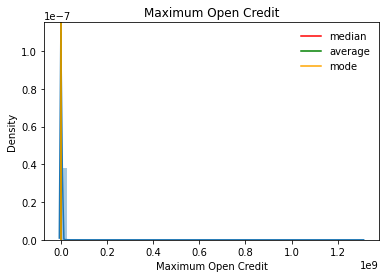

<Figure size 432x288 with 0 Axes>

Признак: Number of Credit Problems
count    7500.000000
mean        0.170000
std         0.498598
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         7.000000
Name: Number of Credit Problems, dtype: float64
0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64
Медиана со средним значением отличаются на 0.34 стандартных отклонения
Максимальное значение больше, чем медиана + 3 стандартных отклонения (выходит из 99,7% диапазона данных)


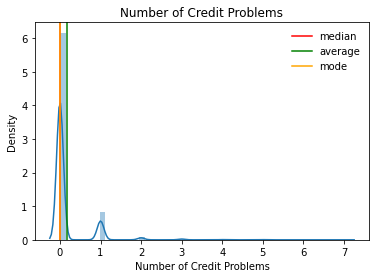

<Figure size 432x288 with 0 Axes>

Признак: Months since last delinquent
count    3419.000000
mean       34.692600
std        21.688807
min         0.000000
25%        16.000000
50%        32.000000
75%        50.000000
max       118.000000
Name: Months since last delinquent, dtype: float64
14.0     76
29.0     71
33.0     68
8.0      68
19.0     65
         ..
84.0      1
86.0      1
91.0      1
118.0     1
92.0      1
Name: Months since last delinquent, Length: 89, dtype: int64
Медиана со средним значением отличаются на 0.12 стандартных отклонения
Максимальное значение больше, чем медиана + 3 стандартных отклонения (выходит из 99,7% диапазона данных)


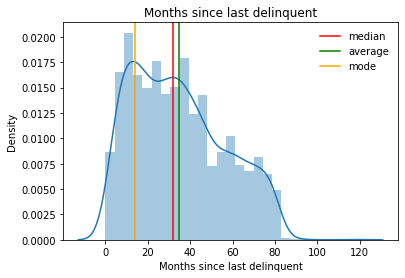

<Figure size 432x288 with 0 Axes>

Признак: Bankruptcies
count    7486.000000
mean        0.117152
std         0.347192
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         4.000000
Name: Bankruptcies, dtype: float64
0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64
Медиана со средним значением отличаются на 0.34 стандартных отклонения
Максимальное значение больше, чем медиана + 3 стандартных отклонения (выходит из 99,7% диапазона данных)


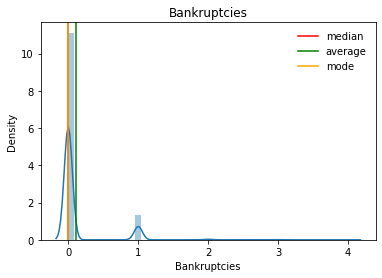

<Figure size 432x288 with 0 Axes>

Признак: Current Loan Amount
count         7500.0
mean      11873178.0
std       31926124.0
min          11242.0
25%         180169.0
50%         309573.0
75%         519882.0
max      100000000.0
Name: Current Loan Amount, dtype: float64
100000000.0    870
89298.0          6
218064.0         6
216106.0         5
265826.0         5
              ... 
222860.0         1
104324.0         1
201080.0         1
427812.0         1
191136.0         1
Name: Current Loan Amount, Length: 5386, dtype: int64
Медиана со средним значением отличаются на 0.36 стандартных отклонения
Максимальное значение больше, чем медиана + 3 стандартных отклонения (выходит из 99,7% диапазона данных)


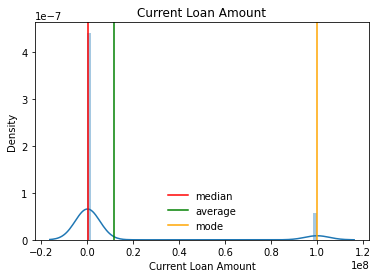

<Figure size 432x288 with 0 Axes>

Признак: Current Credit Balance
count    7.500000e+03
mean     2.898332e+05
std      3.178714e+05
min      0.000000e+00
25%      1.142565e+05
50%      2.093230e+05
75%      3.604062e+05
max      6.506797e+06
Name: Current Credit Balance, dtype: float64
0.0         53
191710.0     5
106818.0     4
136401.0     4
82289.0      4
            ..
64733.0      1
66709.0      1
42199.0      1
871036.0     1
346902.0     1
Name: Current Credit Balance, Length: 6592, dtype: int64
Медиана со средним значением отличаются на 0.25 стандартных отклонения
Максимальное значение больше, чем медиана + 3 стандартных отклонения (выходит из 99,7% диапазона данных)


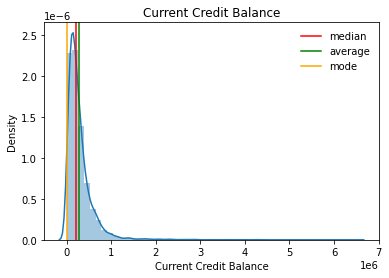

<Figure size 432x288 with 0 Axes>

Признак: Monthly Debt
count      7500.000000
mean      18314.453125
std       11926.764648
min           0.000000
25%       10067.500000
50%       16076.500000
75%       23818.000000
max      136679.000000
Name: Monthly Debt, dtype: float64
0.0        6
19667.0    4
19222.0    4
19277.0    3
9669.0     3
          ..
12857.0    1
10777.0    1
29267.0    1
25050.0    1
31119.0    1
Name: Monthly Debt, Length: 6716, dtype: int64
Медиана со средним значением отличаются на 0.19 стандартных отклонения
Максимальное значение больше, чем медиана + 3 стандартных отклонения (выходит из 99,7% диапазона данных)


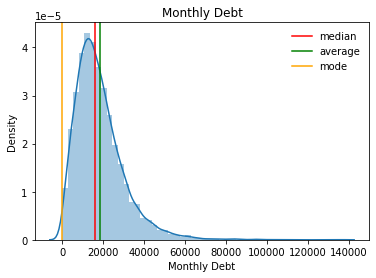

<Figure size 432x288 with 0 Axes>

Признак: Credit Score
count    5943.000000
mean     1151.087524
std      1604.451416
min       585.000000
25%       711.000000
50%       731.000000
75%       743.000000
max      7510.000000
Name: Credit Score, dtype: float64
740.0     169
747.0     168
748.0     157
745.0     152
742.0     151
         ... 
629.0       1
606.0       1
6830.0      1
6670.0      1
620.0       1
Name: Credit Score, Length: 268, dtype: int64
Медиана со средним значением отличаются на 0.26 стандартных отклонения
Максимальное значение больше, чем медиана + 3 стандартных отклонения (выходит из 99,7% диапазона данных)


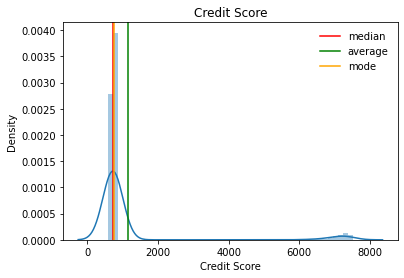

<Figure size 432x288 with 0 Axes>

Признак: Credit Default
count    7500.000000
mean        0.281733
std         0.449874
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Credit Default, dtype: float64
0    5387
1    2113
Name: Credit Default, dtype: int64
Медиана со средним значением отличаются на 0.63 стандартных отклонения


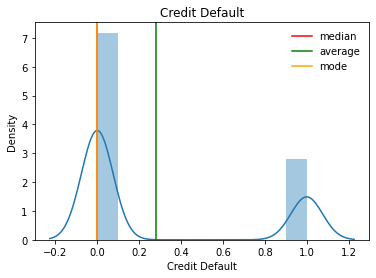

<Figure size 432x288 with 0 Axes>

In [19]:
for feature in numerical:
    print(f"Признак: {feature}")
    print(train_df[feature].describe())
    print(train_df[feature].value_counts())
    median, avg, mode = deviations(train_df[feature])
    hist_plot(train_df, feature, median, avg, mode)
    print("="*80)

### Выводы
* Большинству данных потребуется логарифмическая или ранговая нормализация
* Tax Liens, Number of Credit Problems, Bankruptcies - категориальные признаки (???)
* Очень не нравится в Current Loan Amount значение 100млн. Возможно, выброс.
* Maximum Open Credit, Current Credit Balance, Monthly Debt в 0 тоже маловероятен
* Credit Score максимальный 850, всё что больше нужно делить на 10.

In [20]:
class DataProcessor:
        
#     @staticmethod
#     def change_to_category(df):
#         # Переназначим категориальные признаки
#         suspected_categorials = ["Tax Liens"] # "Tax Liens", "Number of Credit Problems", "Bankruptcies", 
#         for col in suspected_categorials:
#             df[col] = df[col].astype("category")
#         return df
    
    @staticmethod
    def remove_outliers(df):
        # уберём выбросы
        df["Current Loan Amount"].loc[df["Current Loan Amount"] >= 99999999] = np.nan
        df["Maximum Open Credit"].loc[df["Maximum Open Credit"] == 0] = np.nan
        df["Current Credit Balance"].loc[df["Current Credit Balance"] == 0] = np.nan
        # df["Monthly Debt"].loc[df["Monthly Debt"] == 0] = np.nan
        df["Credit Score"].loc[df["Credit Score"] > 850] = df["Credit Score"].loc[df["Credit Score"] > 850]//10
        
        # удалим всё, выхоядщее за 3 квантиля
        for feature in df.select_dtypes(exclude="category").columns:
            if "tax" not in feature.lower():
                feature_median = df[feature].quantile(q=0.5)
                feature_std = df[feature].std()
                dist_max = feature_median + feature_std*3
                dist_min = feature_median - feature_std*3
                df[feature][(df[feature] > dist_max) | (df[feature] < dist_min)] = np.nan
        
        return df

    def fit(self, df):
        # уберём выбросы
        df = self.remove_outliers(df)
        # Принудительно переназначим категориальные признаки
        #df = self.change_to_category(df)
        
        # вычислим моды
        self.modes = df.mode().loc[0]

        # подберём замену для пропусков по 10 соседям
        self.cols = df.select_dtypes(exclude="category").columns.to_list()
        self.imputer = KNNImputer(n_neighbors=10, weights="uniform", add_indicator=True)
        imputed = self.imputer.fit_transform(df[self.cols])
        cols_to_add = imputed.shape[1] - len(self.cols)
        self.cols.extend([f"Missing_{x}" for x in range(cols_to_add)])

    
    def transform(self, df):
        # уберём выбросы
        df = self.remove_outliers(df)        
        # Принудительно переназначим категориальные признаки
        #df = self.change_to_category(df)

        # выделим только категориальные данные
        categorical = df.select_dtypes(include="category")
        
        df["Months since last delinquent"].fillna(0, inplace=True)
        
        # автоматически заполним остальные пропуски
        imputed = self.imputer.transform(df.select_dtypes(exclude="category"))
        imputed = pd.DataFrame(imputed, columns=self.cols)
        for feature in imputed.columns:
            if "missing" in feature.lower():
                imputed[feature] = imputed[feature].astype("category")
        
        # заполним категориальные пропуски
        for feature in categorical.columns:
            if categorical[feature].isna().sum()>0:
                categorical[feature + '_nan'] = (categorical[feature].isna() * 1).astype("category")
                categorical[feature].fillna(self.modes.loc[feature], inplace=True)
        
        # вернём назад категориальные данные
        df = pd.concat([imputed, categorical], axis=1)
        
        return df


In [21]:
y = train_df["Credit Default"]
train_df = train_df.drop("Credit Default", axis=1)

## Заполним пропуски и удалим выбросы

In [22]:
processor = DataProcessor()
processor.fit(train_df)
train_df = processor.transform(train_df)
test_df = processor.transform(test_df)

## Построение и оценка базовых моделей

In [23]:
class DummiesEnc:
    def __init__(self):
        self.enc = OneHotEncoder(sparse=False, handle_unknown="ignore")

    def fit_transform(self, df):
        cat_df = pd.DataFrame(self.enc.fit_transform(df.select_dtypes(include=["category", "object"])))
        num_df = df.select_dtypes(exclude="category")
        dummies_df = pd.concat([num_df, cat_df], axis=1)
        return dummies_df
    def transform(self, df):
        cat_df = pd.DataFrame(self.enc.transform(df.select_dtypes(include=["category", "object"])))
        num_df = df.select_dtypes(exclude="category")
        dummies_df = pd.concat([num_df, cat_df], axis=1)
        return dummies_df

In [24]:
def get_splitted(train, y):
    enc = DummiesEnc()
    train_dummies = enc.fit_transform(train)

    scaler = MinMaxScaler() #StandardScaler()
    train_dummies = scaler.fit_transform(train_dummies)

    X_train, X_test, y_train, y_test = train_test_split(train_dummies, y,
                                                        shuffle=True,
                                                        test_size=0.3,
                                                        random_state=42,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [25]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [26]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [27]:
X_train, X_test, y_train, y_test = get_splitted(train_df, y)

model_lr = LogisticRegressionCV()
model_lr.fit(X_train, y_train)

evaluate_preds(model_lr, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.74      0.97      0.84      3771
           1       0.63      0.13      0.22      1479

    accuracy                           0.73      5250
   macro avg       0.68      0.55      0.53      5250
weighted avg       0.71      0.73      0.66      5250

TEST

              precision    recall  f1-score   support

           0       0.74      0.96      0.83      1616
           1       0.57      0.12      0.20       634

    accuracy                           0.73      2250
   macro avg       0.65      0.54      0.52      2250
weighted avg       0.69      0.73      0.66      2250

CONFUSION MATRIX

col_0              0   1
Credit Default          
0               1556  60
1                555  79


## Проверим несовпадение распределения вещественных признаков на трейне и тесте

Monthly Debt


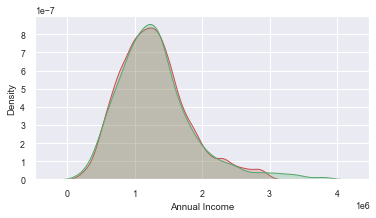

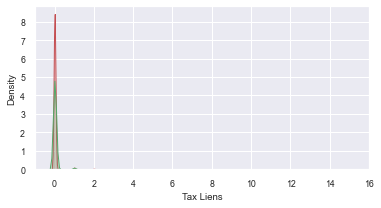

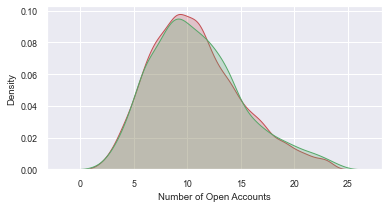

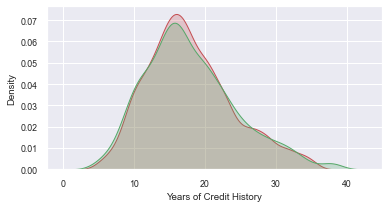

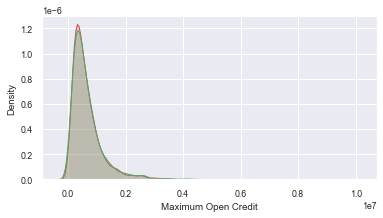

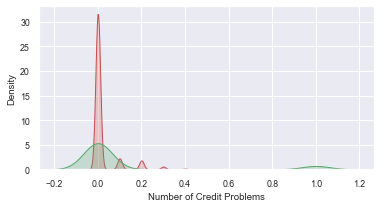

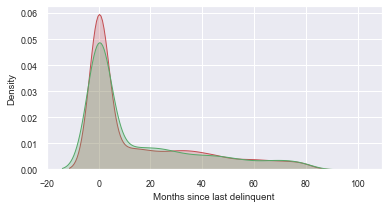

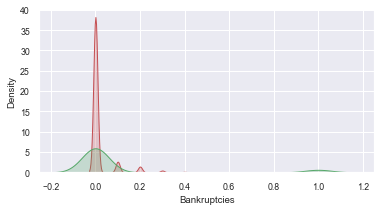

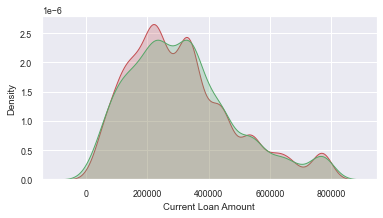

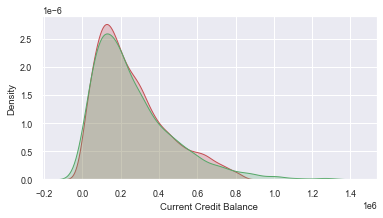

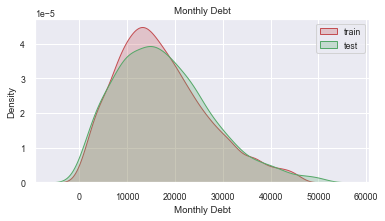

Credit Score


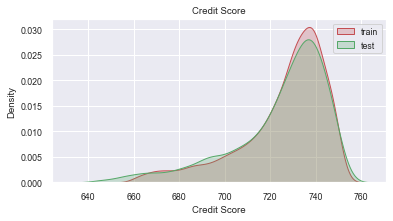

In [28]:
figsize = (6, 3)
for col in train_df.select_dtypes(exclude="category"):
    plt.figure(figsize=figsize)
    sns.set(font_scale=0.8)
    sns.kdeplot(train_df[col], shade=True, label='train', color='r')
    sns.kdeplot(test_df[col], shade=True, label='test', color='g')
    
    if shapiro(train_df[col])[1]>0.05:
        mean_prob = ttest_ind(train_df[col], test_df[col])[1]
    else:
        mean_prob = mannwhitneyu(train_df[col], test_df[col])[1]
    
    if mean_prob < 0.05:
        print(col)
        plt.legend()
        plt.title(col)
        plt.show()
        plt.close()

## Проверим корреляцию с целевой переменной

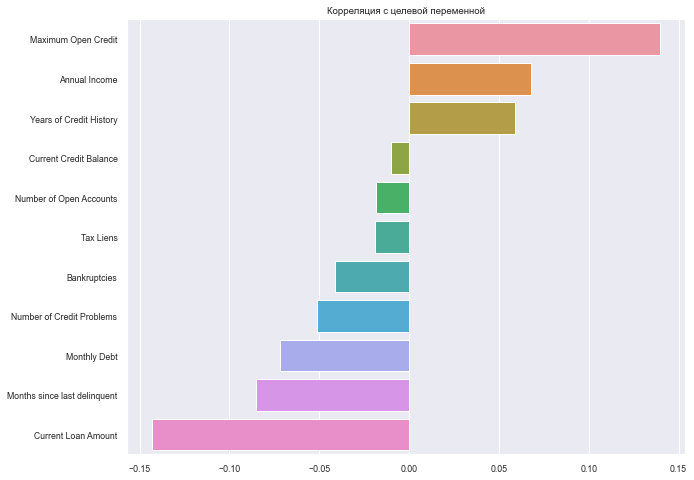

In [29]:
corr_with_target = train_df.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Корреляция с целевой переменной')
plt.show()

## Проверим распределения категориальных признаков на трейне и тесте

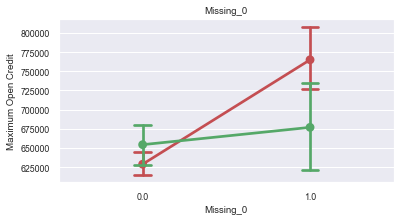

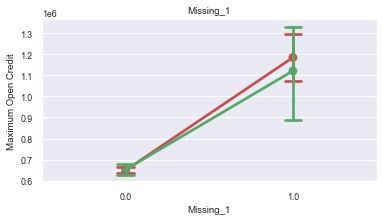

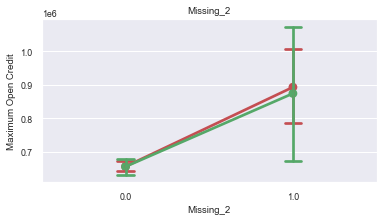

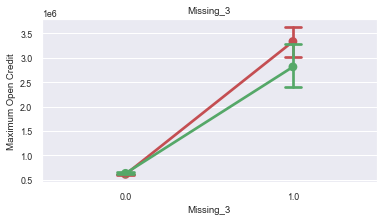

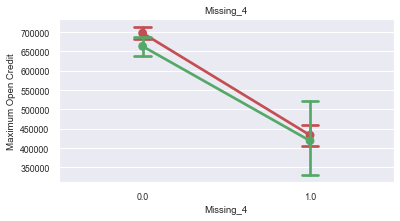

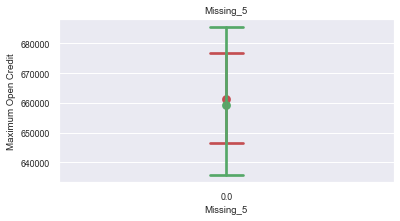

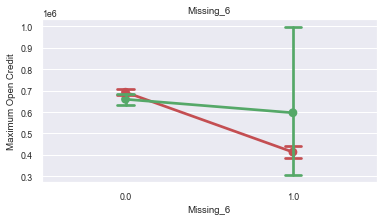

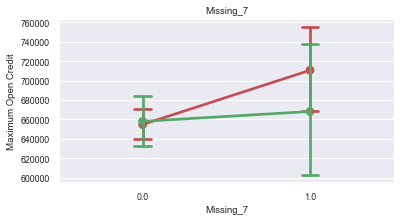

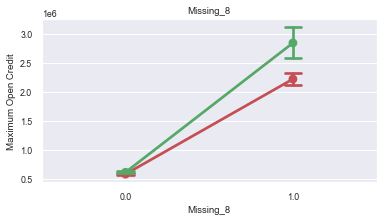

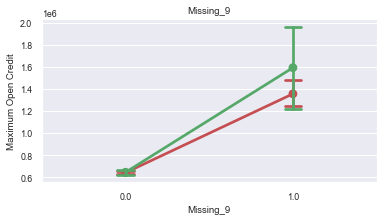

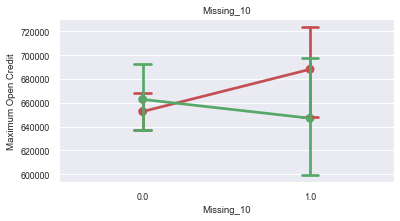

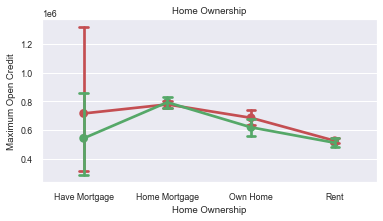

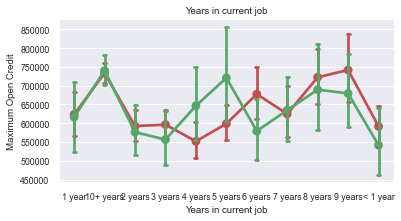

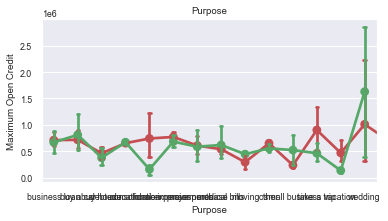

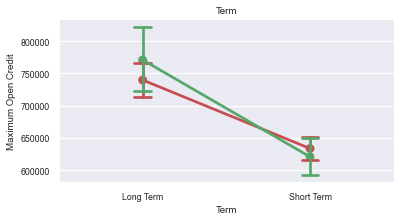

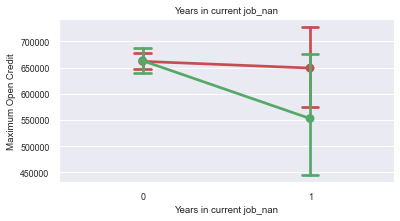

In [30]:
num_feature = 'Maximum Open Credit'
for col in test_df.select_dtypes(include="category"):
    plt.figure(figsize=figsize)
    sns.pointplot(x=col, y=num_feature, data=train_df, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=test_df, capsize=.1, label='test', color='g')
    plt.title(col)
    plt.show()

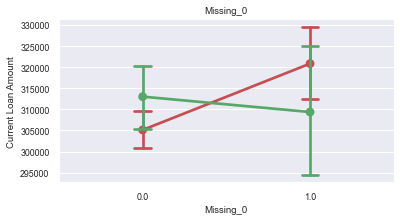

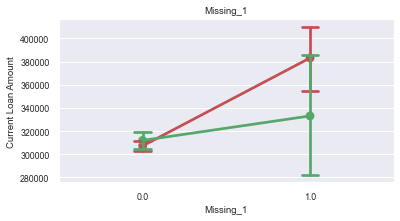

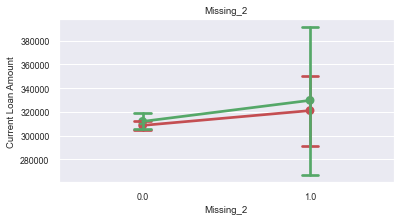

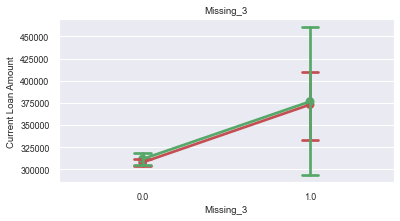

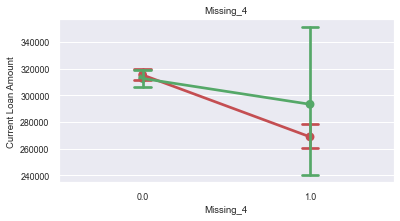

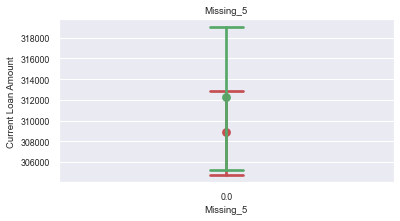

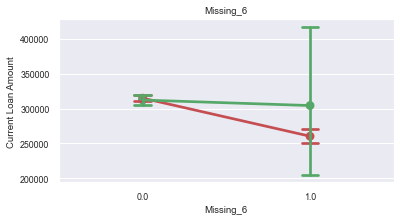

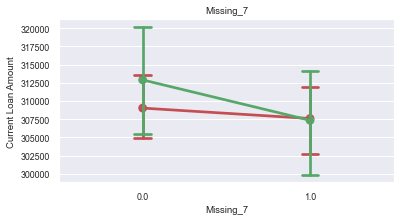

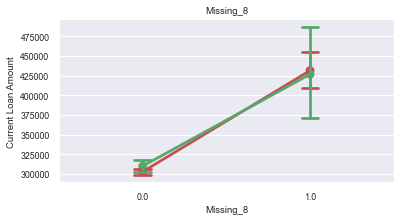

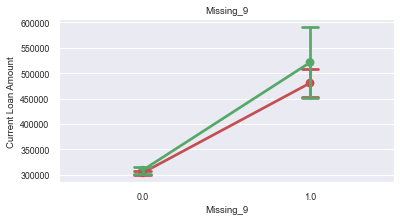

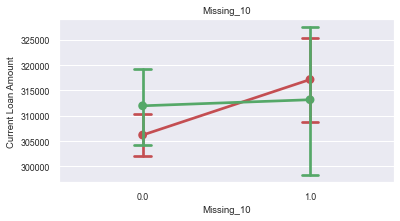

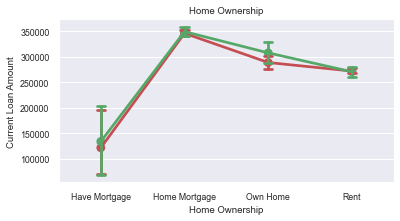

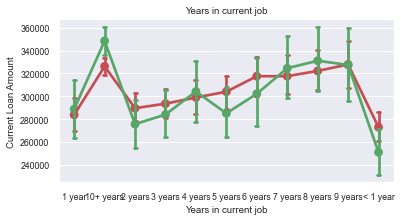

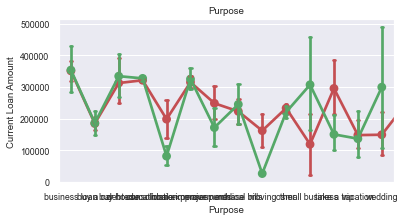

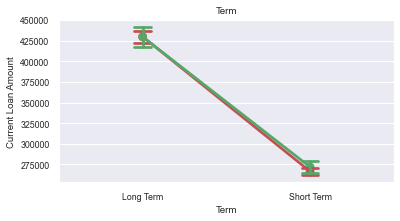

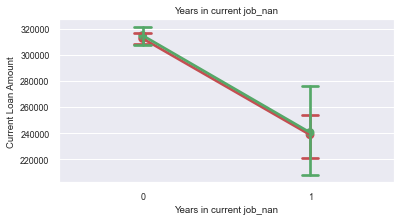

In [31]:
num_feature = 'Current Loan Amount'
for col in test_df.select_dtypes(include="category"):
    plt.figure(figsize=figsize)
    sns.pointplot(x=col, y=num_feature, data=train_df, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=test_df, capsize=.1, label='test', color='g')
    plt.title(col)
    plt.show()

## Проверим согласованность частот

In [32]:
import itertools

def check_consistency(df, y, feature, show=True):
    """Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы
    Альтернативная гипотеза: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы
    Критерий: Хи-квадрат Пирсона
    Уровень значимости  𝛼 : 0.05
    Критическая область: двухсторонняя"""
        
    combineable = []
    variants = set(itertools.combinations(df[feature].unique(), 2))
    full_df = pd.concat([df, y], axis=1)
    full_df['Id'] = full_df.index
    for variant in variants:
        feature_and_target = full_df.loc[full_df[feature].isin(variant), ['Id', feature, 'Credit Default']]
        table = feature_and_target.pivot_table(values='Id', index=feature, columns='Credit Default', aggfunc='count')
        table = table[(table.T != 0).any()]

        chi2, p, _, _ = chi2_contingency(table)
        if p>0.05:
            combineable.append(variant)
    if show:
        plt.figure(figsize=(10, 8))
        sns.pointplot(x=feature, y=y, data=df, capsize=.1,)
        plt.show()
        plt.close()

        print(f"Признаки, которые можно объединить в {feature}: {combineable}")
    else:
        return(len(combineable))

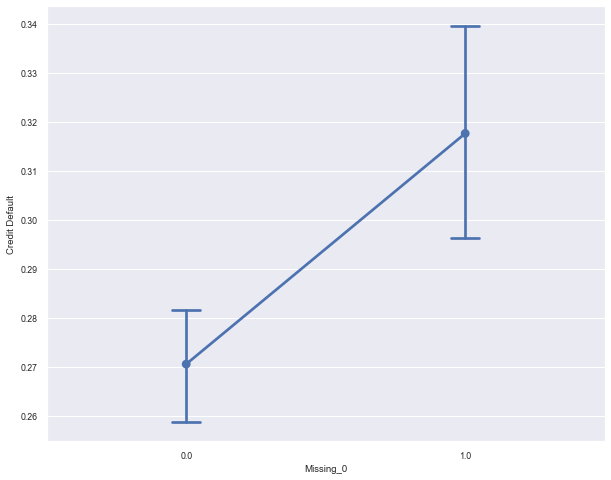

Признаки, которые можно объединить в Missing_0: []


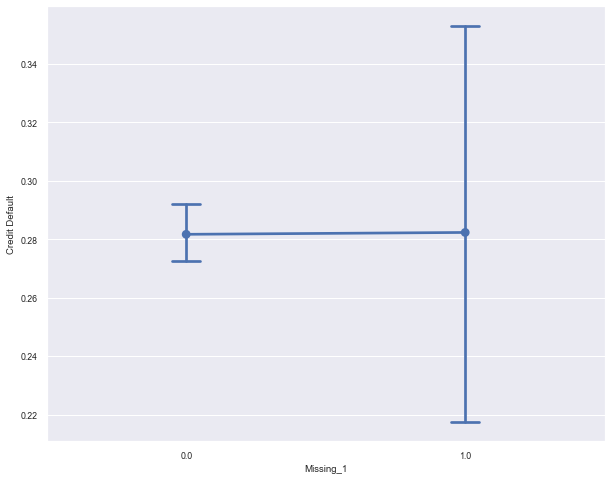

Признаки, которые можно объединить в Missing_1: [(0.0, 1.0)]


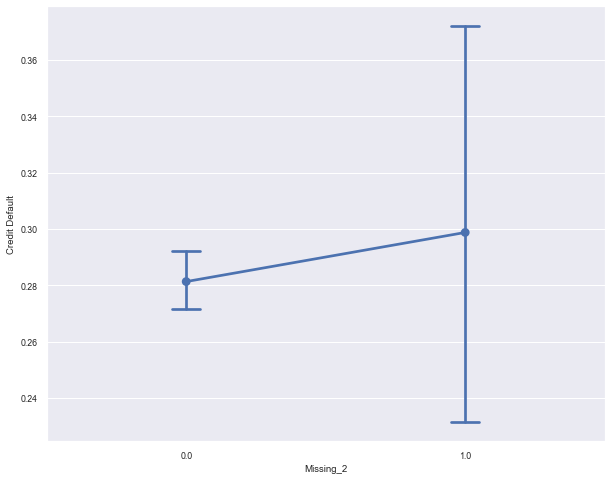

Признаки, которые можно объединить в Missing_2: [(0.0, 1.0)]


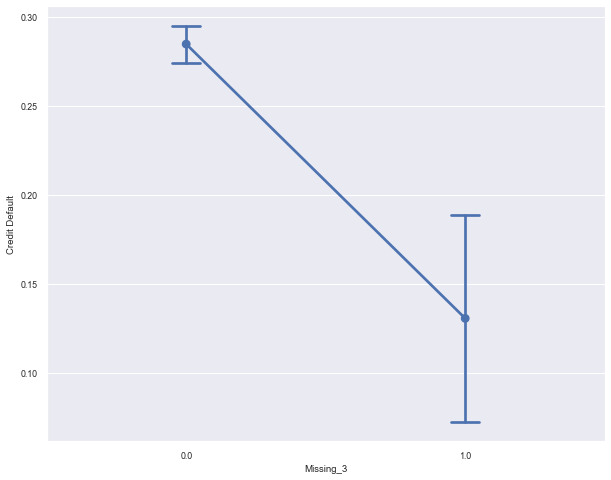

Признаки, которые можно объединить в Missing_3: []


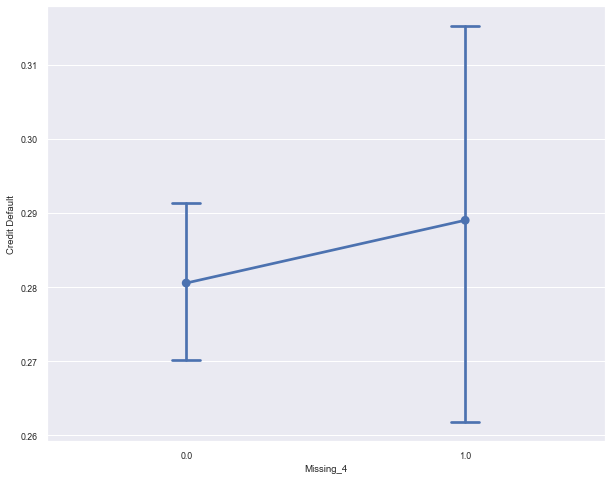

Признаки, которые можно объединить в Missing_4: [(1.0, 0.0)]


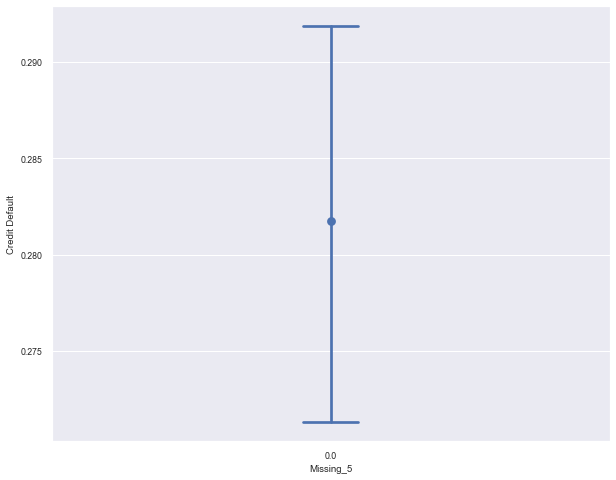

Признаки, которые можно объединить в Missing_5: []


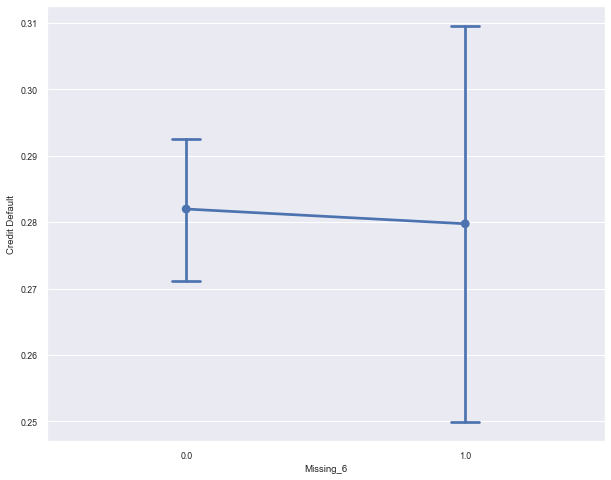

Признаки, которые можно объединить в Missing_6: [(1.0, 0.0)]


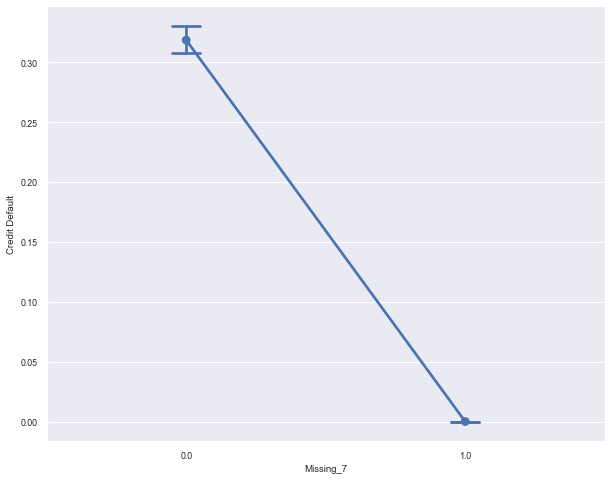

Признаки, которые можно объединить в Missing_7: []


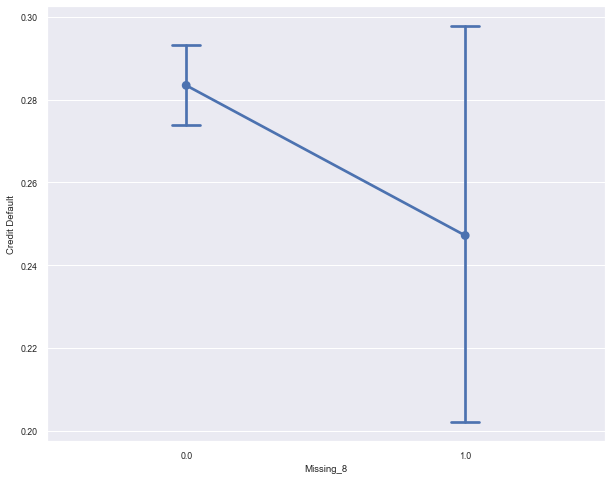

Признаки, которые можно объединить в Missing_8: [(0.0, 1.0)]


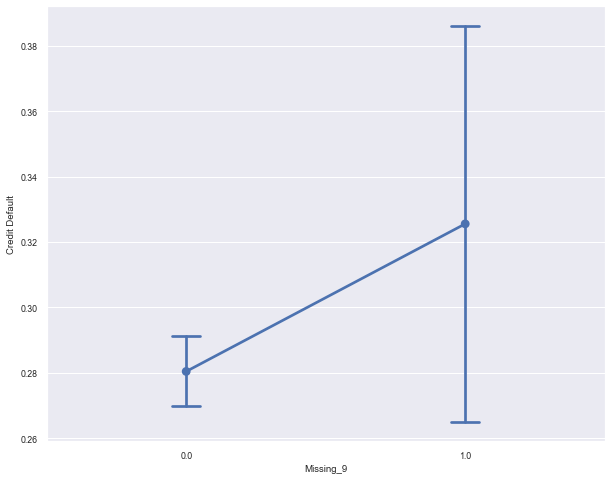

Признаки, которые можно объединить в Missing_9: [(0.0, 1.0)]


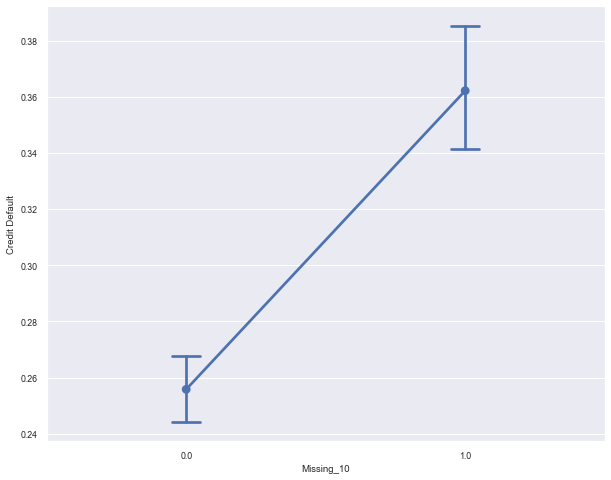

Признаки, которые можно объединить в Missing_10: []


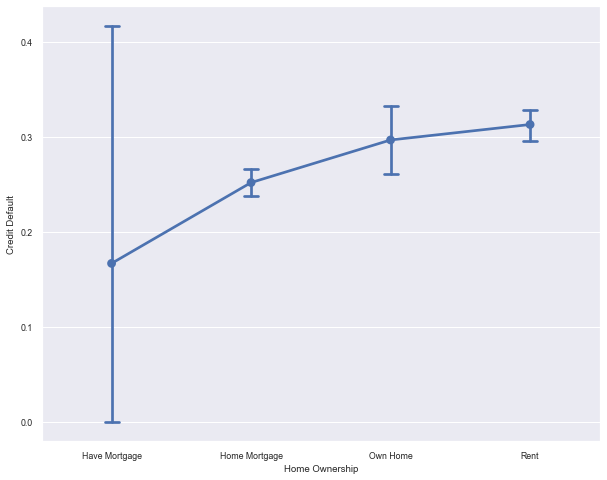

Признаки, которые можно объединить в Home Ownership: [('Rent', 'Have Mortgage'), ('Home Mortgage', 'Have Mortgage'), ('Own Home', 'Have Mortgage'), ('Own Home', 'Rent')]


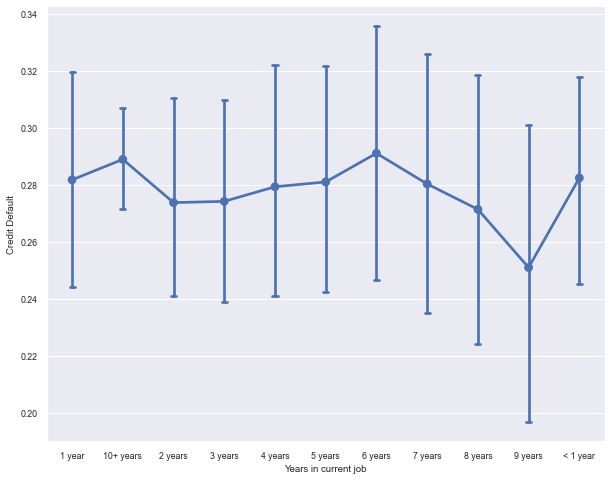

Признаки, которые можно объединить в Years in current job: [('10+ years', '7 years'), ('6 years', '9 years'), ('1 year', '9 years'), ('8 years', '4 years'), ('7 years', '3 years'), ('7 years', '5 years'), ('6 years', '3 years'), ('10+ years', '< 1 year'), ('6 years', '5 years'), ('6 years', '1 year'), ('7 years', '1 year'), ('10+ years', '6 years'), ('1 year', '3 years'), ('< 1 year', '4 years'), ('5 years', '9 years'), ('< 1 year', '9 years'), ('10+ years', '4 years'), ('< 1 year', '3 years'), ('7 years', '2 years'), ('8 years', '9 years'), ('6 years', '2 years'), ('5 years', '3 years'), ('5 years', '1 year'), ('3 years', '9 years'), ('1 year', '2 years'), ('6 years', '7 years'), ('8 years', '3 years'), ('8 years', '1 year'), ('8 years', '5 years'), ('4 years', '9 years'), ('7 years', '< 1 year'), ('10+ years', '8 years'), ('10+ years', '9 years'), ('6 years', '< 1 year'), ('2 years', '9 years'), ('1 year', '< 1 year'), ('5 years', '2 years'), ('< 1 year', '2 years'), ('7 years', '4 y

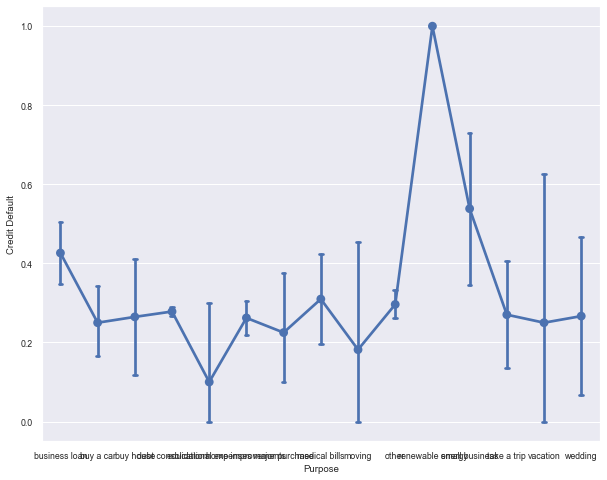

Признаки, которые можно объединить в Purpose: [('other', 'home improvements'), ('debt consolidation', 'major purchase'), ('small business', 'business loan'), ('home improvements', 'take a trip'), ('debt consolidation', 'medical bills'), ('take a trip', 'business loan'), ('buy house', 'vacation'), ('debt consolidation', 'buy house'), ('educational expenses', 'medical bills'), ('buy house', 'renewable energy'), ('buy a car', 'educational expenses'), ('other', 'major purchase'), ('educational expenses', 'buy house'), ('business loan', 'wedding'), ('debt consolidation', 'moving'), ('take a trip', 'wedding'), ('debt consolidation', 'educational expenses'), ('buy a car', 'major purchase'), ('educational expenses', 'moving'), ('buy a car', 'medical bills'), ('moving', 'major purchase'), ('educational expenses', 'vacation'), ('buy a car', 'buy house'), ('other', 'educational expenses'), ('small business', 'medical bills'), ('educational expenses', 'renewable energy'), ('take a trip', 'major pu

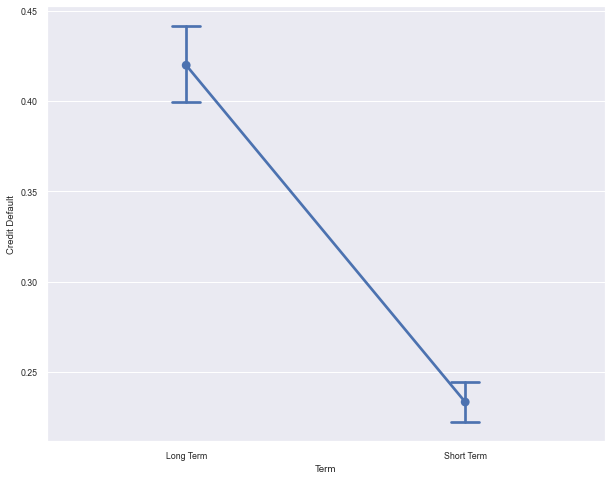

Признаки, которые можно объединить в Term: []


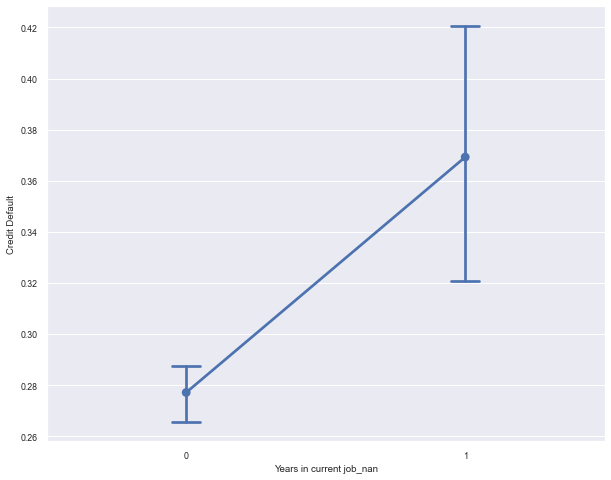

Признаки, которые можно объединить в Years in current job_nan: []


In [33]:
for feature in train_df.select_dtypes(include="category").columns:
    check_consistency(train_df, y, feature)

In [34]:
# from sklearn.manifold import TSNE
# tsne = TSNE(n_components = 2, learning_rate=30, random_state=42, perplexity=30, n_iter=500)
# X_train_tsne = tsne.fit_transform(pd.get_dummies(train_df))
# plt.scatter(X_train_tsne[:, 0], X_train_tsne[:,1])

### Перепробовал массу вариантов с разными параметрами, ничего не видно...

In [35]:
def apply_elbow_method(X):
    """Визуализация для метода 'локтя'"""
    X = pd.get_dummies(X)
    
    distortions = []
    K = range(2,30)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=42).fit(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

    plt.figure(figsize=(10, 8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

In [36]:
# apply_elbow_method(train_df)

In [37]:
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(pd.get_dummies(train_df))

# kmeans = KMeans(n_clusters=13, random_state=42)
# labels = kmeans.fit_predict(X_scaled)
# labels = pd.Series(labels, name='clusters')

# display_clusters_distribution(labels)

### Выглядит прилично, добавим в данные

## Добавим новые признаки

In [38]:
class FeatureGenerator:
    def fit(self, df, target):
        full_df = pd.concat([df,target], axis=1)
        self.purpose_count = df["Purpose"].value_counts().reset_index().rename(columns={"index":"Purpose", "Purpose":"PurposeCount"})
        self.yicj_def = full_df.groupby("Years in current job")["Credit Default"].agg("mean").reset_index().rename(columns={"Credit Default":"CD_YICJ_proba"})
        self.purpose_def = full_df.groupby("Purpose")["Credit Default"].agg("mean").reset_index().rename(columns={"Credit Default":"CD_Purp_prob"})
        self.def_proba_per_problems = full_df.groupby("Number of Credit Problems")["Credit Default"].agg("mean").reset_index().rename(columns={"Credit Default":"CD_NOCP_prob"})
        self.tax_def = full_df.groupby("Tax Liens")["Credit Default"].agg("mean").reset_index().rename(columns={"Credit Default":"CD_TL_prob"})
        self.acc_def = full_df.groupby("Number of Open Accounts")["Credit Default"].agg("mean").reset_index().rename(columns={"Credit Default":"CD_NOA_prob"})
        self.delinquent_def = full_df.groupby("Months since last delinquent")["Credit Default"].agg("mean").reset_index().rename(columns={"Credit Default":"CD_del_prob"})
        self.bankr_def = full_df.groupby("Bankruptcies")["Credit Default"].agg("mean").reset_index().rename(columns={"Credit Default":"CD_bankr_prob"})    
        self.yoch_def = full_df.groupby("Years of Credit History")["Credit Default"].agg("mean").reset_index().rename(columns={"Credit Default":"CD_YOCH_prob"})
        self.ho_def = full_df.groupby("Home Ownership")["Credit Default"].agg("mean").reset_index().rename(columns={"Credit Default":"CD_HO_prob"})
        self.cs_def = full_df.groupby("Credit Score")["Credit Default"].agg("mean").reset_index().rename(columns={"Credit Default":"CD_CS_prob"})
        self.term_def = full_df.groupby("Term")["Credit Default"].agg("mean").reset_index().rename(columns={"Credit Default":"CD_term_prob"})
        self.cs_nocp = full_df.groupby("Credit Score")["Number of Credit Problems"].agg("mean").reset_index().rename(columns={"Number of Credit Problems":"CS_NOCP"})
        
        self.enc = OneHotEncoder(sparse=False, handle_unknown="ignore")
        df_cat = pd.DataFrame(self.enc.fit_transform(df.select_dtypes(include="category")))
        df_num = df.select_dtypes(exclude="category")
        df_dummies = pd.concat([df_num, df_cat], axis=1)
        
        self.scaler = MinMaxScaler()
        df_scaled = self.scaler.fit_transform(df_dummies)
        self.kmeans = KMeans(n_clusters=13, random_state=42)
        self.kmeans.fit(df_scaled)

        self.pcas = dict()
        for feature in df.select_dtypes(include="category").columns:
            if check_consistency(df, y, feature, show=False) > 3:
                pca = PCA(n_components=df[feature].nunique()//2)
                enc = OneHotEncoder(sparse=False, handle_unknown="ignore")
                dummies = enc.fit_transform(pd.DataFrame(df[feature]))
                pca.fit(dummies)
                self.pcas[feature]=(pca, enc)
        
        
        
    def transform(self, df):
        df_cat = pd.DataFrame(self.enc.transform(df.select_dtypes(include="category")))
        df_num = df.select_dtypes(exclude="category")
        df_dummies = pd.concat([df_num, df_cat], axis=1)
        
        df_scaled = self.scaler.transform(df_dummies)
        kmeans_labels = pd.Series(self.kmeans.predict(df_scaled), name='cluster').astype("category")
        df = pd.concat([df, kmeans_labels], axis=1)
        
        # target encoding
        df = df.merge(self.purpose_count, on="Purpose", how="left")
        df = df.merge(self.purpose_def, on="Purpose", how="left")
        df = df.merge(self.yicj_def, on="Years in current job", how="left")
        df = df.merge(self.def_proba_per_problems, on="Number of Credit Problems", how="left")
        df = df.merge(self.tax_def, on="Tax Liens", how="left")
        df = df.merge(self.acc_def, on="Number of Open Accounts", how="left")
        df = df.merge(self.delinquent_def, on="Months since last delinquent", how="left")
        df = df.merge(self.bankr_def, on="Bankruptcies", how="left")
        df = df.merge(self.yoch_def, on="Years of Credit History", how="left")
        df = df.merge(self.ho_def, on="Home Ownership", how="left")
        df = df.merge(self.cs_def, on="Credit Score", how="left")
        df = df.merge(self.term_def, on="Term", how="left")
        df = df.merge(self.cs_nocp, on="Credit Score", how="left")
                
        
        # feature encoding
        df["Debt_to_income"] = df["Monthly Debt"]/(df["Annual Income"])
        df["Income_to_debt"] = (df["Annual Income"])/df["Monthly Debt"]
        df["Income_to_loan"] = (df["Annual Income"])/df["Current Loan Amount"]
        df["Payback_period"] = df["Current Loan Amount"]/df["Annual Income"]
        df["Payback_period_2"] = df["Current Credit Balance"]/df["Annual Income"]
        df["Payback_period_3"] = (df["Current Loan Amount"] + df["Current Credit Balance"])/df["Annual Income"]
        df["Loan left"] = df["Current Loan Amount"]/df["Maximum Open Credit"]
        df["Loan left_2"] = df["Maximum Open Credit"]/df["Current Loan Amount"]
        df["Loan_to_credit_ratio"] = df["Current Loan Amount"]/df["Current Credit Balance"]
        df["Credit left"] = df["Current Credit Balance"]/df["Maximum Open Credit"]
        df["Problems per credit"] = df["Number of Credit Problems"]/df["Maximum Open Credit"]
        df["Income per credit"] = df["Annual Income"]/df["Maximum Open Credit"]
        df["Problems per account"] = df["Number of Credit Problems"]/df["Number of Open Accounts"]
                
        # заменим некторые категории на PCA
        for feature, value in self.pcas.items():
            pca = value[0]
            enc = value[1]
            reduced = pd.DataFrame(pca.transform(enc.transform(pd.DataFrame(df[feature]))))
            columns = reduced.columns.tolist()
            columns = {col: feature+"_reduced_"+str(col) for col in columns}
            reduced.rename(columns=columns, inplace=True)
            df = pd.concat([df, reduced], axis=1)
            for col in str(df_cat.columns.tolist()):
                if feature.lower() in col.lower():
                    df_cat.drop(col, axis=1, inplace=True)
        
#         # разобъём данные на квантили
#         quantiles = 10
#         new_cat = pd.DataFrame()
#         for feature in df.columns:
#             try:
#                 if df[feature].nunique() > 50:
#                     #print(f"Working on {feature}, uniques = {df[feature].nunique()}")
#                     new_cat[feature + "_quant"] = pd.qcut(df[feature],
#                                                   q=np.linspace(0, 1, quantiles+1), # (0, .25, .5, .75, 1.)
#                                                   labels=range(quantiles), # (0, 1, 2, 3)
#                                                   duplicates="drop")#.astype("category") 
#             except KeyError:
#                 #print(f"{feature} raised KeyError!")
#                 continue
#             except ValueError:
#                 #print(f"{feature} raised ValueError!")
#                 continue
#         final_num = df.select_dtypes(exclude="category")
#         final_df = pd.concat([final_num, new_cat, df_cat], axis=1)
        
        final_df = df
        
        # если есть медианы - заполняем пропуски, нет - генерим медианы
        try:
            final_df.fillna(self.medians, inplace=True)
            final_df.fillna(self.modes, inplace=True)
            for feature in final_df.columns:
                try:
                    final_df[feature] = final_df[feature].replace(np.inf, final_df[feature].median())
                except TypeError:
                    continue
            
        except:
            self.medians = final_df.median()
            self.modes = final_df.mode()
            for feature in final_df.columns:
                try:
                    final_df[feature] = final_df[feature].replace(np.inf, final_df[feature].median())
                except TypeError:
                    continue        
        
        return final_df

In [39]:
feature_generator = FeatureGenerator()
feature_generator.fit(train_df, y)
train_df = feature_generator.transform(train_df)
test_df = feature_generator.transform(test_df)

In [40]:
# проверим пропуски
print(f"Train NaNs: {train_df.isna().sum().sum()}")
print(f"Test Nans: {test_df.isna().sum().sum()}")
print(test_df.columns[test_df.isna().any()].tolist())

Train NaNs: 0
Test Nans: 0
[]


## Проверим эффективность признаков

In [41]:
X_train, X_test, y_train, y_test = get_splitted(train_df, y)

model_lr = LogisticRegressionCV()
model_lr.fit(X_train, y_train)

evaluate_preds(model_lr, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.80      0.92      0.85      3771
           1       0.66      0.40      0.50      1479

    accuracy                           0.77      5250
   macro avg       0.73      0.66      0.67      5250
weighted avg       0.76      0.77      0.75      5250

TEST

              precision    recall  f1-score   support

           0       0.79      0.92      0.85      1616
           1       0.64      0.37      0.47       634

    accuracy                           0.76      2250
   macro avg       0.71      0.64      0.66      2250
weighted avg       0.75      0.76      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1484  132
1                400  234


## KNN

In [42]:
from sklearn.neighbors import KNeighborsClassifier
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

evaluate_preds(model_knn, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.81      0.92      0.86      3771
           1       0.67      0.43      0.53      1479

    accuracy                           0.78      5250
   macro avg       0.74      0.68      0.69      5250
weighted avg       0.77      0.78      0.76      5250

TEST

              precision    recall  f1-score   support

           0       0.75      0.85      0.80      1616
           1       0.41      0.26      0.32       634

    accuracy                           0.69      2250
   macro avg       0.58      0.56      0.56      2250
weighted avg       0.65      0.69      0.66      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1381  235
1                468  166


## Дерево решений

In [43]:
y.value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [44]:
disbalance = round(y.value_counts().max()/y.value_counts().min(),2)
disbalance

2.55

In [45]:
from sklearn.tree import DecisionTreeClassifier
model_tree = DecisionTreeClassifier(random_state=21,
                                    class_weight={0:1, 1:disbalance},
                                    max_depth=4
                                    )
# from yellowbrick.classifier.threshold import discrimination_threshold
# from yellowbrick.classifier import DiscriminationThreshold

# # Instantiate the visualizer with the classification model
# #discrimination_threshold(final_model, X_train, y_train)
# visualizer = DiscriminationThreshold(model_tree)
# visualizer.fit(X_train, y_train)        # Fit the data to the visualizer
# visualizer.show()

model_tree.fit(X_train, y_train)

evaluate_preds(model_tree, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.50      0.65      3771
           1       0.40      0.85      0.55      1479

    accuracy                           0.60      5250
   macro avg       0.65      0.68      0.60      5250
weighted avg       0.76      0.60      0.62      5250

TEST

              precision    recall  f1-score   support

           0       0.89      0.52      0.65      1616
           1       0.40      0.84      0.54       634

    accuracy                           0.61      2250
   macro avg       0.65      0.68      0.60      2250
weighted avg       0.75      0.61      0.62      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               833  783
1               104  530


## Бустинговые алгоритмы

*XGBoost*

In [46]:
%%time
from xgboost import XGBClassifier

model_xgb = XGBClassifier(random_state=42,
#                               n_estimators=100
                             )
model_xgb.fit(X_train, y_train)

evaluate_preds(model_xgb, X_train, X_test, y_train, y_test)

[10:29:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3771
           1       1.00      0.96      0.98      1479

    accuracy                           0.99      5250
   macro avg       0.99      0.98      0.99      5250
weighted avg       0.99      0.99      0.99      5250

TEST

              precision    recall  f1-score   support

           0       0.78      0.89      0.83      1616
           1       0.56      0.36      0.43       634

    accuracy                           0.74      2250
   macro avg       0.67      0.62      0.63      2250
weighted avg       0.72      0.74      0.72      2250

CONFUSION MATRIX

col_0

Жуткое переобучение

*LightGBM*

In [47]:
%%time
from lightgbm import LGBMClassifier
model_lgbm = LGBMClassifier(random_state=42, 
                                 class_weight={0:1, 1:disbalance},
#                                  n_estimators=100
                                )
model_lgbm.fit(X_train, y_train)

evaluate_preds(model_lgbm, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.99      0.92      0.96      3771
           1       0.83      0.98      0.90      1479

    accuracy                           0.94      5250
   macro avg       0.91      0.95      0.93      5250
weighted avg       0.95      0.94      0.94      5250

TEST

              precision    recall  f1-score   support

           0       0.83      0.76      0.80      1616
           1       0.50      0.60      0.54       634

    accuracy                           0.72      2250
   macro avg       0.66      0.68      0.67      2250
weighted avg       0.74      0.72      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1236  380
1                256  378
Wall time: 408 ms


Не намного лучше

*CatBoost*

In [48]:
%%time
from catboost import CatBoostClassifier
model_catb = CatBoostClassifier(silent=True, random_state=42,
                               class_weights=[1,disbalance])
model_catb.fit(X_train, y_train)

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.98      0.89      0.93      3771
           1       0.77      0.95      0.85      1479

    accuracy                           0.90      5250
   macro avg       0.87      0.92      0.89      5250
weighted avg       0.92      0.90      0.91      5250

TEST

              precision    recall  f1-score   support

           0       0.84      0.76      0.80      1616
           1       0.51      0.64      0.57       634

    accuracy                           0.72      2250
   macro avg       0.68      0.70      0.68      2250
weighted avg       0.75      0.72      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1221  395
1                227  407
Wall time: 9.05 s


In [49]:
categories = train_df.select_dtypes(include="category").columns.tolist()
categories

['Missing_0',
 'Missing_1',
 'Missing_2',
 'Missing_3',
 'Missing_4',
 'Missing_5',
 'Missing_6',
 'Missing_7',
 'Missing_8',
 'Missing_9',
 'Missing_10',
 'Home Ownership',
 'Years in current job',
 'Purpose',
 'Term',
 'Years in current job_nan',
 'cluster']

In [50]:
# catboost'у не понравились первые столбцы, переведём их в строки
for feature in categories:
    train_df[feature] = train_df[feature].astype("str")

In [51]:
X_train, X_test, y_train, y_test = train_test_split(train_df, y,
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y)

model_catb = CatBoostClassifier(silent=True, random_state=42,
                                class_weights=[1,disbalance],
                                cat_features=categories,
                                eval_metric='F1',
                                early_stopping_rounds=20,
                                use_best_model=True,
                                custom_metric=['Precision', 'Recall'])
#model_catb.fit(X_train, y_train)
model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.55      0.68      3771
           1       0.41      0.80      0.54      1479

    accuracy                           0.62      5250
   macro avg       0.64      0.68      0.61      5250
weighted avg       0.75      0.62      0.64      5250

TEST

              precision    recall  f1-score   support

           0       0.88      0.58      0.70      1616
           1       0.43      0.79      0.56       634

    accuracy                           0.64      2250
   macro avg       0.65      0.69      0.63      2250
weighted avg       0.75      0.64      0.66      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               940  676
1               130  504


## Выбор лучшей модели и подбор гиперпараметров

In [52]:
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':42,
     'cat_features':categories,
     'eval_metric':'F1',
     'early_stopping_rounds':20
}
model_catb = CatBoostClassifier(**frozen_params)

In [53]:
params = {'iterations':[50, 200, 500, 700, 1500],
          'max_depth':[3, 5, 7]}

In [54]:
cv = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

In [55]:
grid_search = model_catb.grid_search(params, X_train, y_train, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6883003901
bestIteration = 3

0:	loss: 0.6883004	best: 0.6883004 (0)	total: 574ms	remaining: 8.04s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7063666803
bestIteration = 90

1:	loss: 0.7063667	best: 0.7063667 (1)	total: 2.59s	remaining: 16.8s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7063666803
bestIteration = 90

2:	loss: 0.7063667	best: 0.7063667 (1)	total: 4.19s	remaining: 16.8s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7063666803
bestIteration = 90

3:	loss: 0.7063667	best: 0.7063667 (1)	total: 5.72s	remaining: 15.7s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7063666803
bestIteration = 90

4:	loss: 0.7063667	best: 0.7063667 (1)	total: 7.41s	remaining: 14.8s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6860706834
bestIteration = 1

5:	loss: 0.6860707	best: 0.7063667 (1)	total: 7.87s	remaining: 

In [56]:
grid_search["params"]

{'depth': 3, 'iterations': 200}

## Обучение и оценка финальной модели

In [57]:
%%time

final_model = CatBoostClassifier(**frozen_params, iterations=200, max_depth=7)

# from yellowbrick.classifier.threshold import discrimination_threshold
# from yellowbrick.classifier import DiscriminationThreshold

# Instantiate the visualizer with the classification model
#discrimination_threshold(final_model, X_train, y_train)
# visualizer = DiscriminationThreshold(final_model)
# visualizer.fit(X_train, y_train)        # Fit the data to the visualizer
# visualizer.show()

final_model.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

evaluate_preds(final_model, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.72      0.80      3771
           1       0.54      0.82      0.65      1479

    accuracy                           0.75      5250
   macro avg       0.72      0.77      0.73      5250
weighted avg       0.81      0.75      0.76      5250

TEST

              precision    recall  f1-score   support

           0       0.87      0.69      0.77      1616
           1       0.49      0.74      0.59       634

    accuracy                           0.71      2250
   macro avg       0.68      0.72      0.68      2250
weighted avg       0.76      0.71      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1119  497
1                165  469
Wall time: 4.16 s


## Балансировка целевой переменной

In [58]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

In [59]:
def init_models():
    model_lr = LogisticRegressionCV(random_state=42)
    model_knn = KNeighborsClassifier()
    model_tree = DecisionTreeClassifier(random_state=42)
    model_xgb = XGBClassifier(random_state=42)
    model_lgbm = LGBMClassifier(random_state=42)
    model_catb = CatBoostClassifier(silent=True, random_state=42)

    models = {
        'lr': model_lr,
        'knn': model_knn,
        'tree': model_tree,
        'xgb': model_xgb,
        'lgbm': model_lgbm,
        'cat': model_catb
    }
    return models

In [60]:
def get_metrics(report):
    f1_macro = report['macro avg']['f1-score']
    f1_0 = report['0']['f1-score']
    f1_1 = report['1']['f1-score']
    return f1_macro, f1_0, f1_1

In [61]:
def run_experiment(X_train, X_test, y_train, y_test, method='not'):
    assert method in ['not', 'over', 'under', 'tomek', 'smote'], 'Неправильный метод сэмплирования'
    
    models = init_models()
    
    stata = pd.DataFrame()
    for name, model in models.items():
        model.fit(X_train, y_train)
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)

        report_train = classification_report(y_train, pred_train, output_dict=True)
        report_test = classification_report(y_test, pred_test, output_dict=True)
        #f1_macro_train, f1_0_train, f1_1_train = get_metrics(report_train)
        f1_macro_test, f1_0_test, f1_1_test = get_metrics(report_test)

        stata = stata.append({
            'model_name': name,
            #f'f1_macro_train_{method}': f1_macro_train,
            f'f1_macro_test_{method}': f1_macro_test,
            #f'f1_0_train_{method}': f1_0_train,
            f'f1_0_test_{method}': f1_0_test,
            #f'f1_1_train_{method}': f1_1_train,
            f'f1_1_test_{method}': f1_1_test
        }, ignore_index=True)
    return stata, models

In [62]:
X_train, X_test, y_train, y_test = get_splitted(reduce_mem_usage(train_df), y)
#X_train, X_test, y_train, y_test = get_splitted(train_df, y)
stata_not_balanced, models_not_balanced = run_experiment(X_train, X_test, y_train, y_test, method='not')
stata_not_balanced

Memory usage of dataframe is 3.26 MB
Memory usage after optimization is: 1.66 MB
Decreased by 49.2%
[10:30:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


f1_0_test_not  f1_1_test_not  f1_macro_test_not model_name
0       0.849432       0.459184           0.654308         lr
1       0.797114       0.320773           0.558943        knn
2       0.752506       0.396024           0.574265       tree
3       0.830058       0.434615           0.632337        xgb
4       0.834763       0.423154           0.628958       lgbm
5       0.842016       0.423554           0.632785        cat

*Oversampling*

In [63]:
from imblearn.over_sampling import SMOTE
X_train, X_test, y_train, y_test = get_splitted(train_df, y)

oversample = SMOTE(n_jobs=-1, k_neighbors=10)
print(f"Original dataset shape: {X_train.shape}, {y_train.shape}")
X_res, y_res = oversample.fit_resample(X_train, y_train)
print(f"Resampled dataset shape: {X_res.shape}, {y_res.shape}")

Original dataset shape: (5250, 120), (5250,)
Resampled dataset shape: (7542, 120), (7542,)


In [64]:
smote_balanced, models_balanced = run_experiment(X_res, X_test, y_res, y_test, method='smote')
smote_balanced

[10:31:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


f1_0_test_smote  f1_1_test_smote  f1_macro_test_smote model_name
0         0.788207         0.596514             0.692361         lr
1         0.681134         0.445526             0.563330        knn
2         0.755598         0.443959             0.599779       tree
3         0.814371         0.465517             0.639944        xgb
4         0.824625         0.500855             0.662740       lgbm
5         0.836114         0.519231             0.677673        cat

In [65]:
from imblearn.under_sampling import TomekLinks
tl = TomekLinks()
X_tomek, y_tomek = tl.fit_resample(X_train, y_train)

In [66]:
tomek_balanced, models_balanced = run_experiment(X_tomek, X_test, y_tomek, y_test, method='tomek')
tomek_balanced

[10:31:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


f1_0_test_tomek  f1_1_test_tomek  f1_macro_test_tomek model_name
0         0.842660         0.505980             0.674320         lr
1         0.778782         0.379019             0.578901        knn
2         0.765997         0.431402             0.598700       tree
3         0.819076         0.469869             0.644473        xgb
4         0.831660         0.488330             0.659995       lgbm
5         0.838106         0.486085             0.662096        cat

In [67]:
def correlation_matrix(df):
    df = df.copy()
#     df = pd.get_dummies(df)
    plt.figure(figsize=(20,20))
    sns.set(font_scale=0.8)
    corr_matrix = df.corr()
    corr_matrix = np.round(corr_matrix, 2)
    corr_matrix[np.abs(corr_matrix)<0.3] = 0
    sns.heatmap(corr_matrix, annot=True, linewidth=.5, cmap="coolwarm")
    plt.title("Матрица корреляции")
    plt.plot()

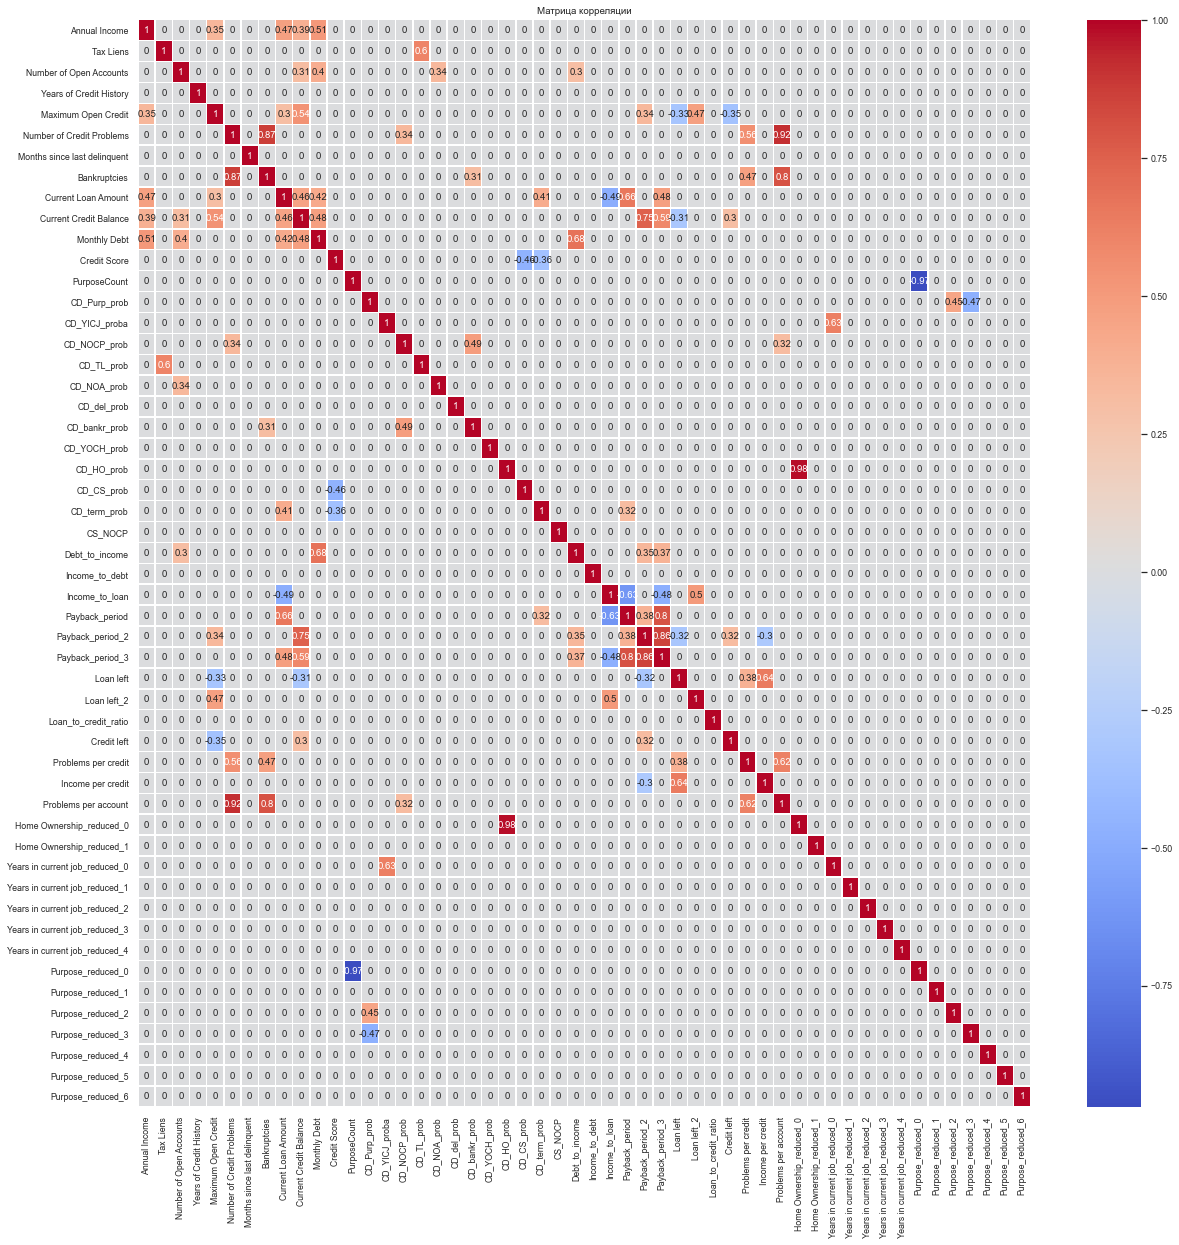

In [68]:
correlation_matrix(train_df)

### Выводы
Много кореллирующих данных, можно будет очень хорошо уменьшить размерность с помощью PCA

# Финальная финальная модель :)

In [69]:
final_train = pd.get_dummies(train_df)
final_test = pd.get_dummies(test_df)

In [70]:
train_cols = final_train.columns.to_list()
test_cols = final_test.columns.to_list()
cols_to_drop = set(train_cols) - set(test_cols)
final_train.drop(cols_to_drop, axis=1, inplace=True)

In [79]:
# oversample = SMOTE(n_jobs=-1, k_neighbors=10)
# print(f"Original dataset shape: {final_train.shape}, {y.shape}")
# final_train, y = oversample.fit_resample(final_train, y)
# print(f"Resampled dataset shape: {final_train.shape}, {y.shape}")

from imblearn.under_sampling import TomekLinks
tl = TomekLinks()
final_train, y = tl.fit_resample(final_train, y)

### Подбор финальных гиперпараметров

In [80]:
disbalance = round(y.value_counts().max()/y.value_counts().min(),2)
disbalance

2.16

In [81]:
frozen_params = {
     'silent':True,
     'random_state':42,
     'eval_metric':'F1',
     'early_stopping_rounds':20,
     'bagging_temperature': 1,
     'leaf_estimation_method': "Newton",
     'task_type':"CPU",
     'class_weights': [1, disbalance]
}
model = CatBoostClassifier(**frozen_params)

In [82]:
params = {'iterations': range(100,500,100),
          'max_depth':[3, 5, 7],
          'learning_rate' : [0.03, 0.1],
          'l2_leaf_reg': np.arange(2,8,0.1)
         }

In [83]:
cv = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

In [84]:
X_train, X_test, y_train, y_test = train_test_split(final_train, y,
                                                        shuffle=True,
                                                        test_size=0.3,
                                                        random_state=42,
                                                        stratify=y)

In [85]:
grid_search = model.grid_search(params, X_train, y_train, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.7342793517
bestIteration = 93

0:	loss: 0.7342794	best: 0.7342794 (0)	total: 701ms	remaining: 16m 48s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.728864296
bestIteration = 20

1:	loss: 0.7288643	best: 0.7342794 (0)	total: 798ms	remaining: 9m 33s

bestTest = 0.7296479083
bestIteration = 86

2:	loss: 0.7296479	best: 0.7342794 (0)	total: 1.07s	remaining: 8m 33s

bestTest = 0.7403625564
bestIteration = 85

3:	loss: 0.7403626	best: 0.7403626 (3)	total: 1.42s	remaining: 8m 28s

bestTest = 0.7265192636
bestIteration = 99

4:	loss: 0.7265193	best: 0.7403626 (3)	total: 1.77s	remaining: 8m 29s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7244629413
bestIteration = 38

5:	loss: 0.7244629	best: 0.7403626 (3)	total: 2.01s	remaining: 7m 59s

bestTest = 0.7285872925
bestIteration = 99

6:	loss: 0.7285873	best: 0.7403626 (3)	total: 2.38s	remaining: 8m 7s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7359872842
bestItera

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7173565816
bestIteration = 41

56:	loss: 0.7173566	best: 0.7403626 (3)	total: 14s	remaining: 5m 40s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.733245068
bestIteration = 43

57:	loss: 0.7332451	best: 0.7403626 (3)	total: 14.2s	remaining: 5m 39s

bestTest = 0.7328658725
bestIteration = 99

58:	loss: 0.7328659	best: 0.7403626 (3)	total: 14.6s	remaining: 5m 42s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7315782033
bestIteration = 44

59:	loss: 0.7315782	best: 0.7403626 (3)	total: 15s	remaining: 5m 43s

bestTest = 0.7310580254
bestIteration = 98

60:	loss: 0.7310580	best: 0.7403626 (3)	total: 15.3s	remaining: 5m 45s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7313150743
bestIteration = 32

61:	loss: 0.7313151	best: 0.7403626 (3)	total: 15.5s	remaining: 5m 43s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7252802884
bestIteration 


bestTest = 0.7254896454
bestIteration = 99

112:	loss: 0.7254896	best: 0.7403626 (3)	total: 28.7s	remaining: 5m 37s

bestTest = 0.7364483878
bestIteration = 95

113:	loss: 0.7364484	best: 0.7403626 (3)	total: 29.1s	remaining: 5m 37s

bestTest = 0.728864296
bestIteration = 89

114:	loss: 0.7288643	best: 0.7403626 (3)	total: 29.4s	remaining: 5m 39s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7284681926
bestIteration = 39

115:	loss: 0.7284682	best: 0.7403626 (3)	total: 29.6s	remaining: 5m 38s

bestTest = 0.728864296
bestIteration = 84

116:	loss: 0.7288643	best: 0.7403626 (3)	total: 30s	remaining: 5m 38s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7254896454
bestIteration = 28

117:	loss: 0.7254896	best: 0.7403626 (3)	total: 30.2s	remaining: 5m 38s

bestTest = 0.7367234237
bestIteration = 98

118:	loss: 0.7367234	best: 0.7403626 (3)	total: 30.6s	remaining: 5m 40s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.737922436

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7280691824
bestIteration = 100

162:	loss: 0.7280692	best: 0.7412512 (142)	total: 48.6s	remaining: 6m 20s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7275518085
bestIteration = 33

163:	loss: 0.7275518	best: 0.7412512 (142)	total: 48.7s	remaining: 6m 19s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7314460647
bestIteration = 101

164:	loss: 0.7314461	best: 0.7412512 (142)	total: 49.1s	remaining: 6m 19s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.726923082
bestIteration = 23

165:	loss: 0.7269231	best: 0.7412512 (142)	total: 49.2s	remaining: 6m 17s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7252802884
bestIteration = 61

166:	loss: 0.7252803	best: 0.7412512 (142)	total: 49.5s	remaining: 6m 17s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7177107552
bestIteration = 26

167:	loss: 0.7177108	best: 0.741251

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7271482419
bestIteration = 72

210:	loss: 0.7271482	best: 0.7422995 (194)	total: 1m 2s	remaining: 6m 1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7270351695
bestIteration = 25

211:	loss: 0.7270352	best: 0.7422995 (194)	total: 1m 2s	remaining: 6m
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7314460647
bestIteration = 147

212:	loss: 0.7314461	best: 0.7422995 (194)	total: 1m 2s	remaining: 6m 2s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7393284539
bestIteration = 49

213:	loss: 0.7393285	best: 0.7422995 (194)	total: 1m 3s	remaining: 6m 2s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7316990943
bestIteration = 79

214:	loss: 0.7316991	best: 0.7422995 (194)	total: 1m 3s	remaining: 6m 2s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7309282488
bestIteration = 77

215:	loss: 0.7309282	best: 0.7422995 (194)	

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7368778715
bestIteration = 112

258:	loss: 0.7368779	best: 0.7422995 (194)	total: 1m 20s	remaining: 6m 9s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7389699669
bestIteration = 78

259:	loss: 0.7389700	best: 0.7422995 (194)	total: 1m 21s	remaining: 6m 9s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7356865445
bestIteration = 95

260:	loss: 0.7356865	best: 0.7422995 (194)	total: 1m 22s	remaining: 6m 10s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7304017545
bestIteration = 93

261:	loss: 0.7304018	best: 0.7422995 (194)	total: 1m 22s	remaining: 6m 11s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7412512407
bestIteration = 114

262:	loss: 0.7412512	best: 0.7422995 (194)	total: 1m 23s	remaining: 6m 13s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7347148827
bestIteration = 83

263:	loss: 0.7347149	best: 0.74

305:	loss: 0.7301596	best: 0.7422995 (194)	total: 1m 38s	remaining: 6m 6s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7354652037
bestIteration = 117

306:	loss: 0.7354652	best: 0.7422995 (194)	total: 1m 39s	remaining: 6m 6s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7351691986
bestIteration = 43

307:	loss: 0.7351692	best: 0.7422995 (194)	total: 1m 39s	remaining: 6m 5s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7300198857
bestIteration = 97

308:	loss: 0.7300199	best: 0.7422995 (194)	total: 1m 39s	remaining: 6m 5s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7194512711
bestIteration = 10

309:	loss: 0.7194513	best: 0.7422995 (194)	total: 1m 39s	remaining: 6m 4s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7333842678
bestIteration = 91

310:	loss: 0.7333843	best: 0.7422995 (194)	total: 1m 40s	remaining: 6m 4s
Stopped by overfitting detector  (20 iterations wait)

bestT

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7416041593
bestIteration = 144

353:	loss: 0.7416042	best: 0.7422995 (194)	total: 1m 54s	remaining: 5m 51s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7328658725
bestIteration = 116

354:	loss: 0.7328659	best: 0.7422995 (194)	total: 1m 55s	remaining: 5m 52s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7284681926
bestIteration = 39

355:	loss: 0.7284682	best: 0.7422995 (194)	total: 1m 55s	remaining: 5m 51s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7389699669
bestIteration = 121

356:	loss: 0.7389700	best: 0.7422995 (194)	total: 1m 55s	remaining: 5m 51s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7254896454
bestIteration = 28

357:	loss: 0.7254896	best: 0.7422995 (194)	total: 1m 56s	remaining: 5m 50s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.740557559
bestIteration = 112

358:	loss: 0.7405576	best: 0

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7363566972
bestIteration = 55

401:	loss: 0.7363567	best: 0.7422995 (194)	total: 2m 11s	remaining: 5m 39s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7280691824
bestIteration = 100

402:	loss: 0.7280692	best: 0.7422995 (194)	total: 2m 11s	remaining: 5m 39s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7275518085
bestIteration = 33

403:	loss: 0.7275518	best: 0.7422995 (194)	total: 2m 12s	remaining: 5m 38s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7314460647
bestIteration = 101

404:	loss: 0.7314461	best: 0.7422995 (194)	total: 2m 12s	remaining: 5m 38s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.726923082
bestIteration = 23

405:	loss: 0.7269231	best: 0.7422995 (194)	total: 2m 12s	remaining: 5m 37s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7252802884
bestIteration = 61

406:	loss: 0.7252803	best: 0.7

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7305385868
bestIteration = 47

449:	loss: 0.7305386	best: 0.7422995 (194)	total: 2m 25s	remaining: 5m 20s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7271482419
bestIteration = 72

450:	loss: 0.7271482	best: 0.7422995 (194)	total: 2m 26s	remaining: 5m 20s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7270351695
bestIteration = 25

451:	loss: 0.7270352	best: 0.7422995 (194)	total: 2m 26s	remaining: 5m 19s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7314460647
bestIteration = 147

452:	loss: 0.7314461	best: 0.7422995 (194)	total: 2m 26s	remaining: 5m 20s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7393284539
bestIteration = 49

453:	loss: 0.7393285	best: 0.7422995 (194)	total: 2m 27s	remaining: 5m 19s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7316990943
bestIteration = 79

454:	loss: 0.7316991	best: 0.7

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.737399784
bestIteration = 27

497:	loss: 0.7373998	best: 0.7422995 (194)	total: 2m 40s	remaining: 5m 3s

bestTest = 0.7298948133
bestIteration = 83

498:	loss: 0.7298948	best: 0.7422995 (194)	total: 2m 41s	remaining: 5m 4s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7377175732
bestIteration = 25

499:	loss: 0.7377176	best: 0.7422995 (194)	total: 2m 41s	remaining: 5m 3s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7210637018
bestIteration = 32

500:	loss: 0.7210637	best: 0.7422995 (194)	total: 2m 41s	remaining: 5m 3s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.737399784
bestIteration = 21

501:	loss: 0.7373998	best: 0.7422995 (194)	total: 2m 42s	remaining: 5m 2s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7208922487
bestIteration = 27

502:	loss: 0.7208922	best: 0.7422995 (194)	total: 2m 42s	remaining: 5m 2s
Stopped by overfit

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7453181423
bestIteration = 52

547:	loss: 0.7453181	best: 0.7525814 (545)	total: 2m 55s	remaining: 4m 45s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7077402433
bestIteration = 3

548:	loss: 0.7077402	best: 0.7525814 (545)	total: 2m 55s	remaining: 4m 44s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7479139516
bestIteration = 33

549:	loss: 0.7479140	best: 0.7525814 (545)	total: 2m 55s	remaining: 4m 44s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7077402433
bestIteration = 3

550:	loss: 0.7077402	best: 0.7525814 (545)	total: 2m 55s	remaining: 4m 43s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7479139516
bestIteration = 37

551:	loss: 0.7479140	best: 0.7525814 (545)	total: 2m 56s	remaining: 4m 43s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7077402433
bestIteration = 3

552:	loss: 0.7077402	best: 0.75258

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7375579823
bestIteration = 39

597:	loss: 0.7375580	best: 0.7525814 (545)	total: 3m 11s	remaining: 4m 30s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7226034273
bestIteration = 48

598:	loss: 0.7226034	best: 0.7525814 (545)	total: 3m 12s	remaining: 4m 30s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7352402794
bestIteration = 37

599:	loss: 0.7352403	best: 0.7525814 (545)	total: 3m 12s	remaining: 4m 29s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7328658725
bestIteration = 102

600:	loss: 0.7328659	best: 0.7525814 (545)	total: 3m 13s	remaining: 4m 30s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7319646148
bestIteration = 18

601:	loss: 0.7319646	best: 0.7525814 (545)	total: 3m 13s	remaining: 4m 29s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7077402433
bestIteration = 3

602:	loss: 0.7077402	best: 0.75

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7285872925
bestIteration = 25

645:	loss: 0.7285873	best: 0.7525814 (545)	total: 3m 26s	remaining: 4m 13s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7077402433
bestIteration = 3

646:	loss: 0.7077402	best: 0.7525814 (545)	total: 3m 26s	remaining: 4m 12s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7287074412
bestIteration = 43

647:	loss: 0.7287074	best: 0.7525814 (545)	total: 3m 26s	remaining: 4m 12s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7077402433
bestIteration = 3

648:	loss: 0.7077402	best: 0.7525814 (545)	total: 3m 27s	remaining: 4m 12s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7423105609
bestIteration = 49

649:	loss: 0.7423106	best: 0.7525814 (545)	total: 3m 27s	remaining: 4m 12s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7077402433
bestIteration = 3

650:	loss: 0.7077402	best: 0.75258

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7375579823
bestIteration = 29

693:	loss: 0.7375580	best: 0.7525814 (545)	total: 3m 42s	remaining: 3m 59s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7219088499
bestIteration = 29

694:	loss: 0.7219088	best: 0.7525814 (545)	total: 3m 42s	remaining: 3m 58s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7375579823
bestIteration = 29

695:	loss: 0.7375580	best: 0.7525814 (545)	total: 3m 43s	remaining: 3m 58s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7281869657
bestIteration = 78

696:	loss: 0.7281870	best: 0.7525814 (545)	total: 3m 43s	remaining: 3m 58s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7375579823
bestIteration = 29

697:	loss: 0.7375580	best: 0.7525814 (545)	total: 3m 44s	remaining: 3m 58s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7077402433
bestIteration = 3

698:	loss: 0.7077402	best: 0.752

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.737399784
bestIteration = 21

741:	loss: 0.7373998	best: 0.7525814 (545)	total: 3m 59s	remaining: 3m 44s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7208922487
bestIteration = 27

742:	loss: 0.7208922	best: 0.7525814 (545)	total: 3m 59s	remaining: 3m 44s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7393022904
bestIteration = 43

743:	loss: 0.7393023	best: 0.7525814 (545)	total: 3m 59s	remaining: 3m 44s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7077402433
bestIteration = 3

744:	loss: 0.7077402	best: 0.7525814 (545)	total: 4m	remaining: 3m 43s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7375093691
bestIteration = 45

745:	loss: 0.7375094	best: 0.7525814 (545)	total: 4m	remaining: 3m 43s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7077402433
bestIteration = 3

746:	loss: 0.7077402	best: 0.7525814 (545)

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7479139516
bestIteration = 33

789:	loss: 0.7479140	best: 0.7525814 (545)	total: 4m 15s	remaining: 3m 30s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7077402433
bestIteration = 3

790:	loss: 0.7077402	best: 0.7525814 (545)	total: 4m 15s	remaining: 3m 29s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7479139516
bestIteration = 37

791:	loss: 0.7479140	best: 0.7525814 (545)	total: 4m 15s	remaining: 3m 29s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7077402433
bestIteration = 3

792:	loss: 0.7077402	best: 0.7525814 (545)	total: 4m 16s	remaining: 3m 28s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7479139516
bestIteration = 37

793:	loss: 0.7479140	best: 0.7525814 (545)	total: 4m 16s	remaining: 3m 28s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7077402433
bestIteration = 3

794:	loss: 0.7077402	best: 0.75258

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7375579823
bestIteration = 39

837:	loss: 0.7375580	best: 0.7525814 (545)	total: 4m 33s	remaining: 3m 16s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7226034273
bestIteration = 48

838:	loss: 0.7226034	best: 0.7525814 (545)	total: 4m 33s	remaining: 3m 16s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7352402794
bestIteration = 37

839:	loss: 0.7352403	best: 0.7525814 (545)	total: 4m 34s	remaining: 3m 15s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7328658725
bestIteration = 102

840:	loss: 0.7328659	best: 0.7525814 (545)	total: 4m 34s	remaining: 3m 15s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7319646148
bestIteration = 18

841:	loss: 0.7319646	best: 0.7525814 (545)	total: 4m 35s	remaining: 3m 15s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7077402433
bestIteration = 3

842:	loss: 0.7077402	best: 0.75

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7285872925
bestIteration = 25

885:	loss: 0.7285873	best: 0.7525814 (545)	total: 4m 47s	remaining: 2m 59s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7077402433
bestIteration = 3

886:	loss: 0.7077402	best: 0.7525814 (545)	total: 4m 47s	remaining: 2m 59s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7287074412
bestIteration = 43

887:	loss: 0.7287074	best: 0.7525814 (545)	total: 4m 47s	remaining: 2m 58s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7077402433
bestIteration = 3

888:	loss: 0.7077402	best: 0.7525814 (545)	total: 4m 48s	remaining: 2m 58s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7423105609
bestIteration = 49

889:	loss: 0.7423106	best: 0.7525814 (545)	total: 4m 48s	remaining: 2m 58s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7077402433
bestIteration = 3

890:	loss: 0.7077402	best: 0.75258

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7375579823
bestIteration = 29

933:	loss: 0.7375580	best: 0.7525814 (545)	total: 5m 1s	remaining: 2m 43s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7219088499
bestIteration = 29

934:	loss: 0.7219088	best: 0.7525814 (545)	total: 5m 1s	remaining: 2m 42s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7375579823
bestIteration = 29

935:	loss: 0.7375580	best: 0.7525814 (545)	total: 5m 1s	remaining: 2m 42s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7281869657
bestIteration = 78

936:	loss: 0.7281870	best: 0.7525814 (545)	total: 5m 2s	remaining: 2m 42s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7375579823
bestIteration = 29

937:	loss: 0.7375580	best: 0.7525814 (545)	total: 5m 2s	remaining: 2m 41s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7077402433
bestIteration = 3

938:	loss: 0.7077402	best: 0.7525814 

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7383597572
bestIteration = 5

981:	loss: 0.7383598	best: 0.7525814 (545)	total: 5m 20s	remaining: 2m 29s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7222009991
bestIteration = 4

982:	loss: 0.7222010	best: 0.7525814 (545)	total: 5m 20s	remaining: 2m 29s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7383597572
bestIteration = 5

983:	loss: 0.7383598	best: 0.7525814 (545)	total: 5m 20s	remaining: 2m 28s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7253622264
bestIteration = 3

984:	loss: 0.7253622	best: 0.7525814 (545)	total: 5m 21s	remaining: 2m 28s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7383597572
bestIteration = 5

985:	loss: 0.7383598	best: 0.7525814 (545)	total: 5m 21s	remaining: 2m 28s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7253622264
bestIteration = 3

986:	loss: 0.7253622	best: 0.7525814 

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.732620783
bestIteration = 26

1029:	loss: 0.7326208	best: 0.7525814 (545)	total: 5m 39s	remaining: 2m 15s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7248714536
bestIteration = 3

1030:	loss: 0.7248715	best: 0.7525814 (545)	total: 5m 39s	remaining: 2m 14s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7294304285
bestIteration = 4

1031:	loss: 0.7294304	best: 0.7525814 (545)	total: 5m 40s	remaining: 2m 14s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7248714536
bestIteration = 3

1032:	loss: 0.7248715	best: 0.7525814 (545)	total: 5m 40s	remaining: 2m 14s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7294304285
bestIteration = 4

1033:	loss: 0.7294304	best: 0.7525814 (545)	total: 5m 40s	remaining: 2m 13s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7248714536
bestIteration = 3

1034:	loss: 0.7248715	best: 0.75

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7350914214
bestIteration = 20

1077:	loss: 0.7350914	best: 0.7525814 (545)	total: 5m 57s	remaining: 1m 59s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7262416001
bestIteration = 3

1078:	loss: 0.7262416	best: 0.7525814 (545)	total: 5m 57s	remaining: 1m 59s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7350914214
bestIteration = 20

1079:	loss: 0.7350914	best: 0.7525814 (545)	total: 5m 58s	remaining: 1m 59s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7228756424
bestIteration = 9

1080:	loss: 0.7228756	best: 0.7525814 (545)	total: 5m 58s	remaining: 1m 59s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7267712898
bestIteration = 4

1081:	loss: 0.7267713	best: 0.7525814 (545)	total: 5m 58s	remaining: 1m 58s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7240815492
bestIteration = 3

1082:	loss: 0.7240815	best: 0.

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7383597572
bestIteration = 5

1125:	loss: 0.7383598	best: 0.7525814 (545)	total: 6m 13s	remaining: 1m 44s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7248714536
bestIteration = 3

1126:	loss: 0.7248715	best: 0.7525814 (545)	total: 6m 13s	remaining: 1m 43s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7289321292
bestIteration = 4

1127:	loss: 0.7289321	best: 0.7525814 (545)	total: 6m 14s	remaining: 1m 43s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7253622264
bestIteration = 3

1128:	loss: 0.7253622	best: 0.7525814 (545)	total: 6m 14s	remaining: 1m 43s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7289321292
bestIteration = 4

1129:	loss: 0.7289321	best: 0.7525814 (545)	total: 6m 14s	remaining: 1m 42s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7253622264
bestIteration = 3

1130:	loss: 0.7253622	best: 0.75

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.732620783
bestIteration = 16

1173:	loss: 0.7326208	best: 0.7525814 (545)	total: 6m 32s	remaining: 1m 28s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7252622835
bestIteration = 4

1174:	loss: 0.7252623	best: 0.7525814 (545)	total: 6m 32s	remaining: 1m 28s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7271482419
bestIteration = 20

1175:	loss: 0.7271482	best: 0.7525814 (545)	total: 6m 33s	remaining: 1m 28s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7252622835
bestIteration = 4

1176:	loss: 0.7252623	best: 0.7525814 (545)	total: 6m 33s	remaining: 1m 27s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7305385868
bestIteration = 20

1177:	loss: 0.7305386	best: 0.7525814 (545)	total: 6m 34s	remaining: 1m 27s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7252622835
bestIteration = 4

1178:	loss: 0.7252623	best: 0.

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7383597572
bestIteration = 5

1221:	loss: 0.7383598	best: 0.7525814 (545)	total: 6m 50s	remaining: 1m 13s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7222009991
bestIteration = 4

1222:	loss: 0.7222010	best: 0.7525814 (545)	total: 6m 51s	remaining: 1m 12s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7383597572
bestIteration = 5

1223:	loss: 0.7383598	best: 0.7525814 (545)	total: 6m 51s	remaining: 1m 12s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7253622264
bestIteration = 3

1224:	loss: 0.7253622	best: 0.7525814 (545)	total: 6m 51s	remaining: 1m 12s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7383597572
bestIteration = 5

1225:	loss: 0.7383598	best: 0.7525814 (545)	total: 6m 52s	remaining: 1m 11s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7253622264
bestIteration = 3

1226:	loss: 0.7253622	best: 0.75

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.732620783
bestIteration = 26

1269:	loss: 0.7326208	best: 0.7525814 (545)	total: 7m 10s	remaining: 57.7s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7248714536
bestIteration = 3

1270:	loss: 0.7248715	best: 0.7525814 (545)	total: 7m 11s	remaining: 57.3s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7294304285
bestIteration = 4

1271:	loss: 0.7294304	best: 0.7525814 (545)	total: 7m 11s	remaining: 57s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7248714536
bestIteration = 3

1272:	loss: 0.7248715	best: 0.7525814 (545)	total: 7m 11s	remaining: 56.6s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7294304285
bestIteration = 4

1273:	loss: 0.7294304	best: 0.7525814 (545)	total: 7m 12s	remaining: 56.3s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7248714536
bestIteration = 3

1274:	loss: 0.7248715	best: 0.7525814 (

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7350914214
bestIteration = 20

1317:	loss: 0.7350914	best: 0.7525814 (545)	total: 7m 30s	remaining: 41.7s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7262416001
bestIteration = 3

1318:	loss: 0.7262416	best: 0.7525814 (545)	total: 7m 31s	remaining: 41.4s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7350914214
bestIteration = 20

1319:	loss: 0.7350914	best: 0.7525814 (545)	total: 7m 31s	remaining: 41.1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7228756424
bestIteration = 9

1320:	loss: 0.7228756	best: 0.7525814 (545)	total: 7m 32s	remaining: 40.7s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7267712898
bestIteration = 4

1321:	loss: 0.7267713	best: 0.7525814 (545)	total: 7m 32s	remaining: 40.4s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7240815492
bestIteration = 3

1322:	loss: 0.7240815	best: 0.75258

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7383597572
bestIteration = 5

1365:	loss: 0.7383598	best: 0.7525814 (545)	total: 7m 49s	remaining: 25.4s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7248714536
bestIteration = 3

1366:	loss: 0.7248715	best: 0.7525814 (545)	total: 7m 49s	remaining: 25.1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7289321292
bestIteration = 4

1367:	loss: 0.7289321	best: 0.7525814 (545)	total: 7m 50s	remaining: 24.7s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7253622264
bestIteration = 3

1368:	loss: 0.7253622	best: 0.7525814 (545)	total: 7m 50s	remaining: 24.4s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7289321292
bestIteration = 4

1369:	loss: 0.7289321	best: 0.7525814 (545)	total: 7m 50s	remaining: 24.1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7253622264
bestIteration = 3

1370:	loss: 0.7253622	best: 0.7525814

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.732620783
bestIteration = 16

1413:	loss: 0.7326208	best: 0.7525814 (545)	total: 8m 9s	remaining: 8.99s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7252622835
bestIteration = 4

1414:	loss: 0.7252623	best: 0.7525814 (545)	total: 8m 9s	remaining: 8.65s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7271482419
bestIteration = 20

1415:	loss: 0.7271482	best: 0.7525814 (545)	total: 8m 10s	remaining: 8.31s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7252622835
bestIteration = 4

1416:	loss: 0.7252623	best: 0.7525814 (545)	total: 8m 10s	remaining: 7.96s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7305385868
bestIteration = 20

1417:	loss: 0.7305386	best: 0.7525814 (545)	total: 8m 11s	remaining: 7.62s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7252622835
bestIteration = 4

1418:	loss: 0.7252623	best: 0.7525814

In [86]:
final_params = grid_search["params"]
final_params

{'depth': 5,
 'iterations': 100,
 'learning_rate': 0.1,
 'l2_leaf_reg': 5.200000000000003}

In [88]:
best_params = final_params | frozen_params
best_params
# best_params = {'depth': 7,
#  'iterations': 200,
#  'learning_rate': 0.1,
#  'l2_leaf_reg': 4.2,
#  'silent': True,
#  'random_state': 42,
#  'eval_metric': 'F1',
#  'early_stopping_rounds': 20,
#  'bagging_temperature': 1,
#  'leaf_estimation_method': 'Newton',
#  'task_type': 'CPU'}

{'depth': 5,
 'iterations': 100,
 'learning_rate': 0.1,
 'l2_leaf_reg': 5.200000000000003,
 'silent': True,
 'random_state': 42,
 'eval_metric': 'F1',
 'early_stopping_rounds': 20,
 'bagging_temperature': 1,
 'leaf_estimation_method': 'Newton',
 'task_type': 'CPU',
 'class_weights': [1, 2.16]}

### Threshold

In [89]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.arange(0.1, 0.91, 0.01):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3).head(10)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

### Проверка порога

In [90]:
from catboost.utils import select_threshold
from catboost import Pool

# eval_pool = Pool(X_test, y_test)

# threshold = select_threshold(model=model, data=eval_pool, FNR=0.01)
# print(threshold)

## Обучение и оценка финальной модели

In [93]:
train_data = final_train#[important_features]
test_data = final_test#[important_features]

In [94]:
%%time

prod_model = CatBoostClassifier(**best_params)

prod_model.fit(train_data, y)

Wall time: 784 ms


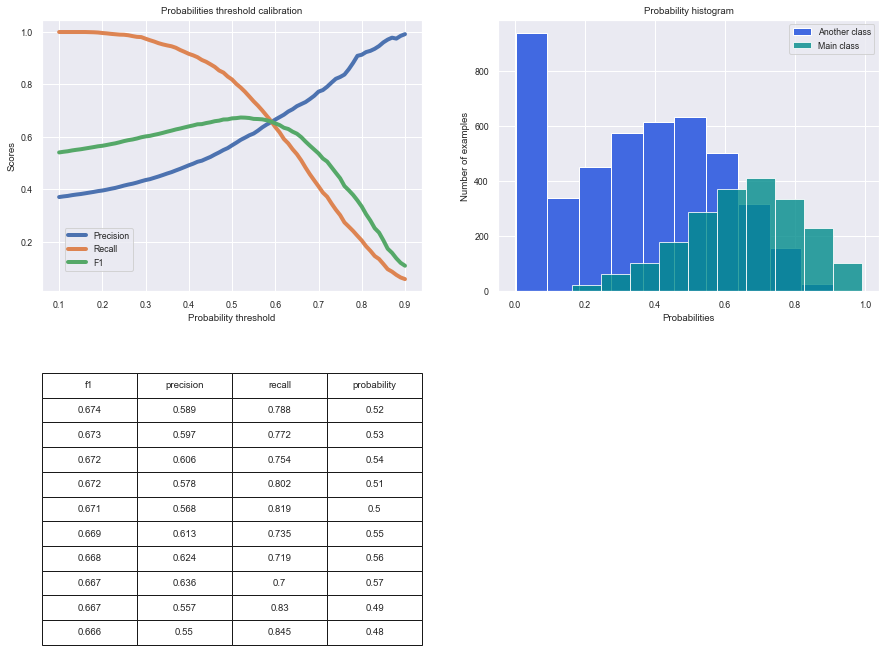

In [95]:
y_pred_probs = prod_model.predict_proba(train_data)
show_proba_calibration_plots(y_pred_probs[:, 1], y)

In [96]:
threshold = 0.52

In [97]:
y_pred_probs = prod_model.predict_proba(test_data)
submit_data = pd.DataFrame(np.where(y_pred_probs[:, 1] >= threshold, 1, 0), columns=(["Credit Default"])).reset_index().rename(columns={"index":"Id"})

In [98]:
# submit_data = prod_model.predict(test_data)
# submit_data = pd.DataFrame(submit_data, columns=(["Credit Default"])).reset_index().rename(columns={"index":"Id"})

In [99]:
submit_data.to_csv('gb_submit.csv', index=False)